## Explainable ML

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [74]:
# load the data
df = pd.read_csv("risk_factors_cervical_cancer.csv")
df.head()

Age Number of sexual partners First sexual intercourse Num of pregnancies  \
0   18                       4.0                     15.0                1.0   
1   15                       1.0                     14.0                1.0   
2   34                       1.0                        ?                1.0   
3   52                       5.0                     16.0                4.0   
4   46                       3.0                     21.0                4.0   

  Smokes Smokes (years) Smokes (packs/year) Hormonal Contraceptives  \
0    0.0            0.0                 0.0                     0.0   
1    0.0            0.0                 0.0                     0.0   
2    0.0            0.0                 0.0                     0.0   
3    1.0           37.0                37.0                     1.0   
4    0.0            0.0                 0.0                     1.0   

  Hormonal Contraceptives (years)  IUD  ... STDs: Time since first diagnosis  \
0                             0.0  0.0  ...                                ?   
1                             0.0  0.0  ...                                ?   
2                             0.0  0.0  ...                                ?   
3                             3.0  0.0  ...                                ?   
4                            15.0  0.0  ...                                ?   

  STDs: Time since last diagnosis Dx:Cancer Dx:CIN Dx:HPV Dx Hinselmann  \
0                               ?         0      0      0  0          0   
1                               ?         0      0      0  0          0   
2                               ?         0      0      0  0          0   
3                               ?         1      0      1  0          0   
4                               ?         0      0      0  0          0   

  Schiller Citology Biopsy  
0        0        0      0  
1        0        0      0  
2        0        0      0  
3        0        0      0  
4        0        0      0  

[5 rows x 36 columns]

In [75]:
# data cleaning
df = df.replace('?', np.nan)
df = df.drop(['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis=1)
df = df.dropna(axis=0)
#df = df._convert(numeric=True)
df = df.astype('float64')

In [76]:
# target: Biopsy 0=healthy, 1=cancer
df.Biopsy.value_counts()

Biopsy
0.0    623
1.0     45
Name: count, dtype: int64

In [77]:
# split data
from sklearn.model_selection import train_test_split
X = df
y = X.pop("Biopsy")
# X = X.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape

(467, 33)

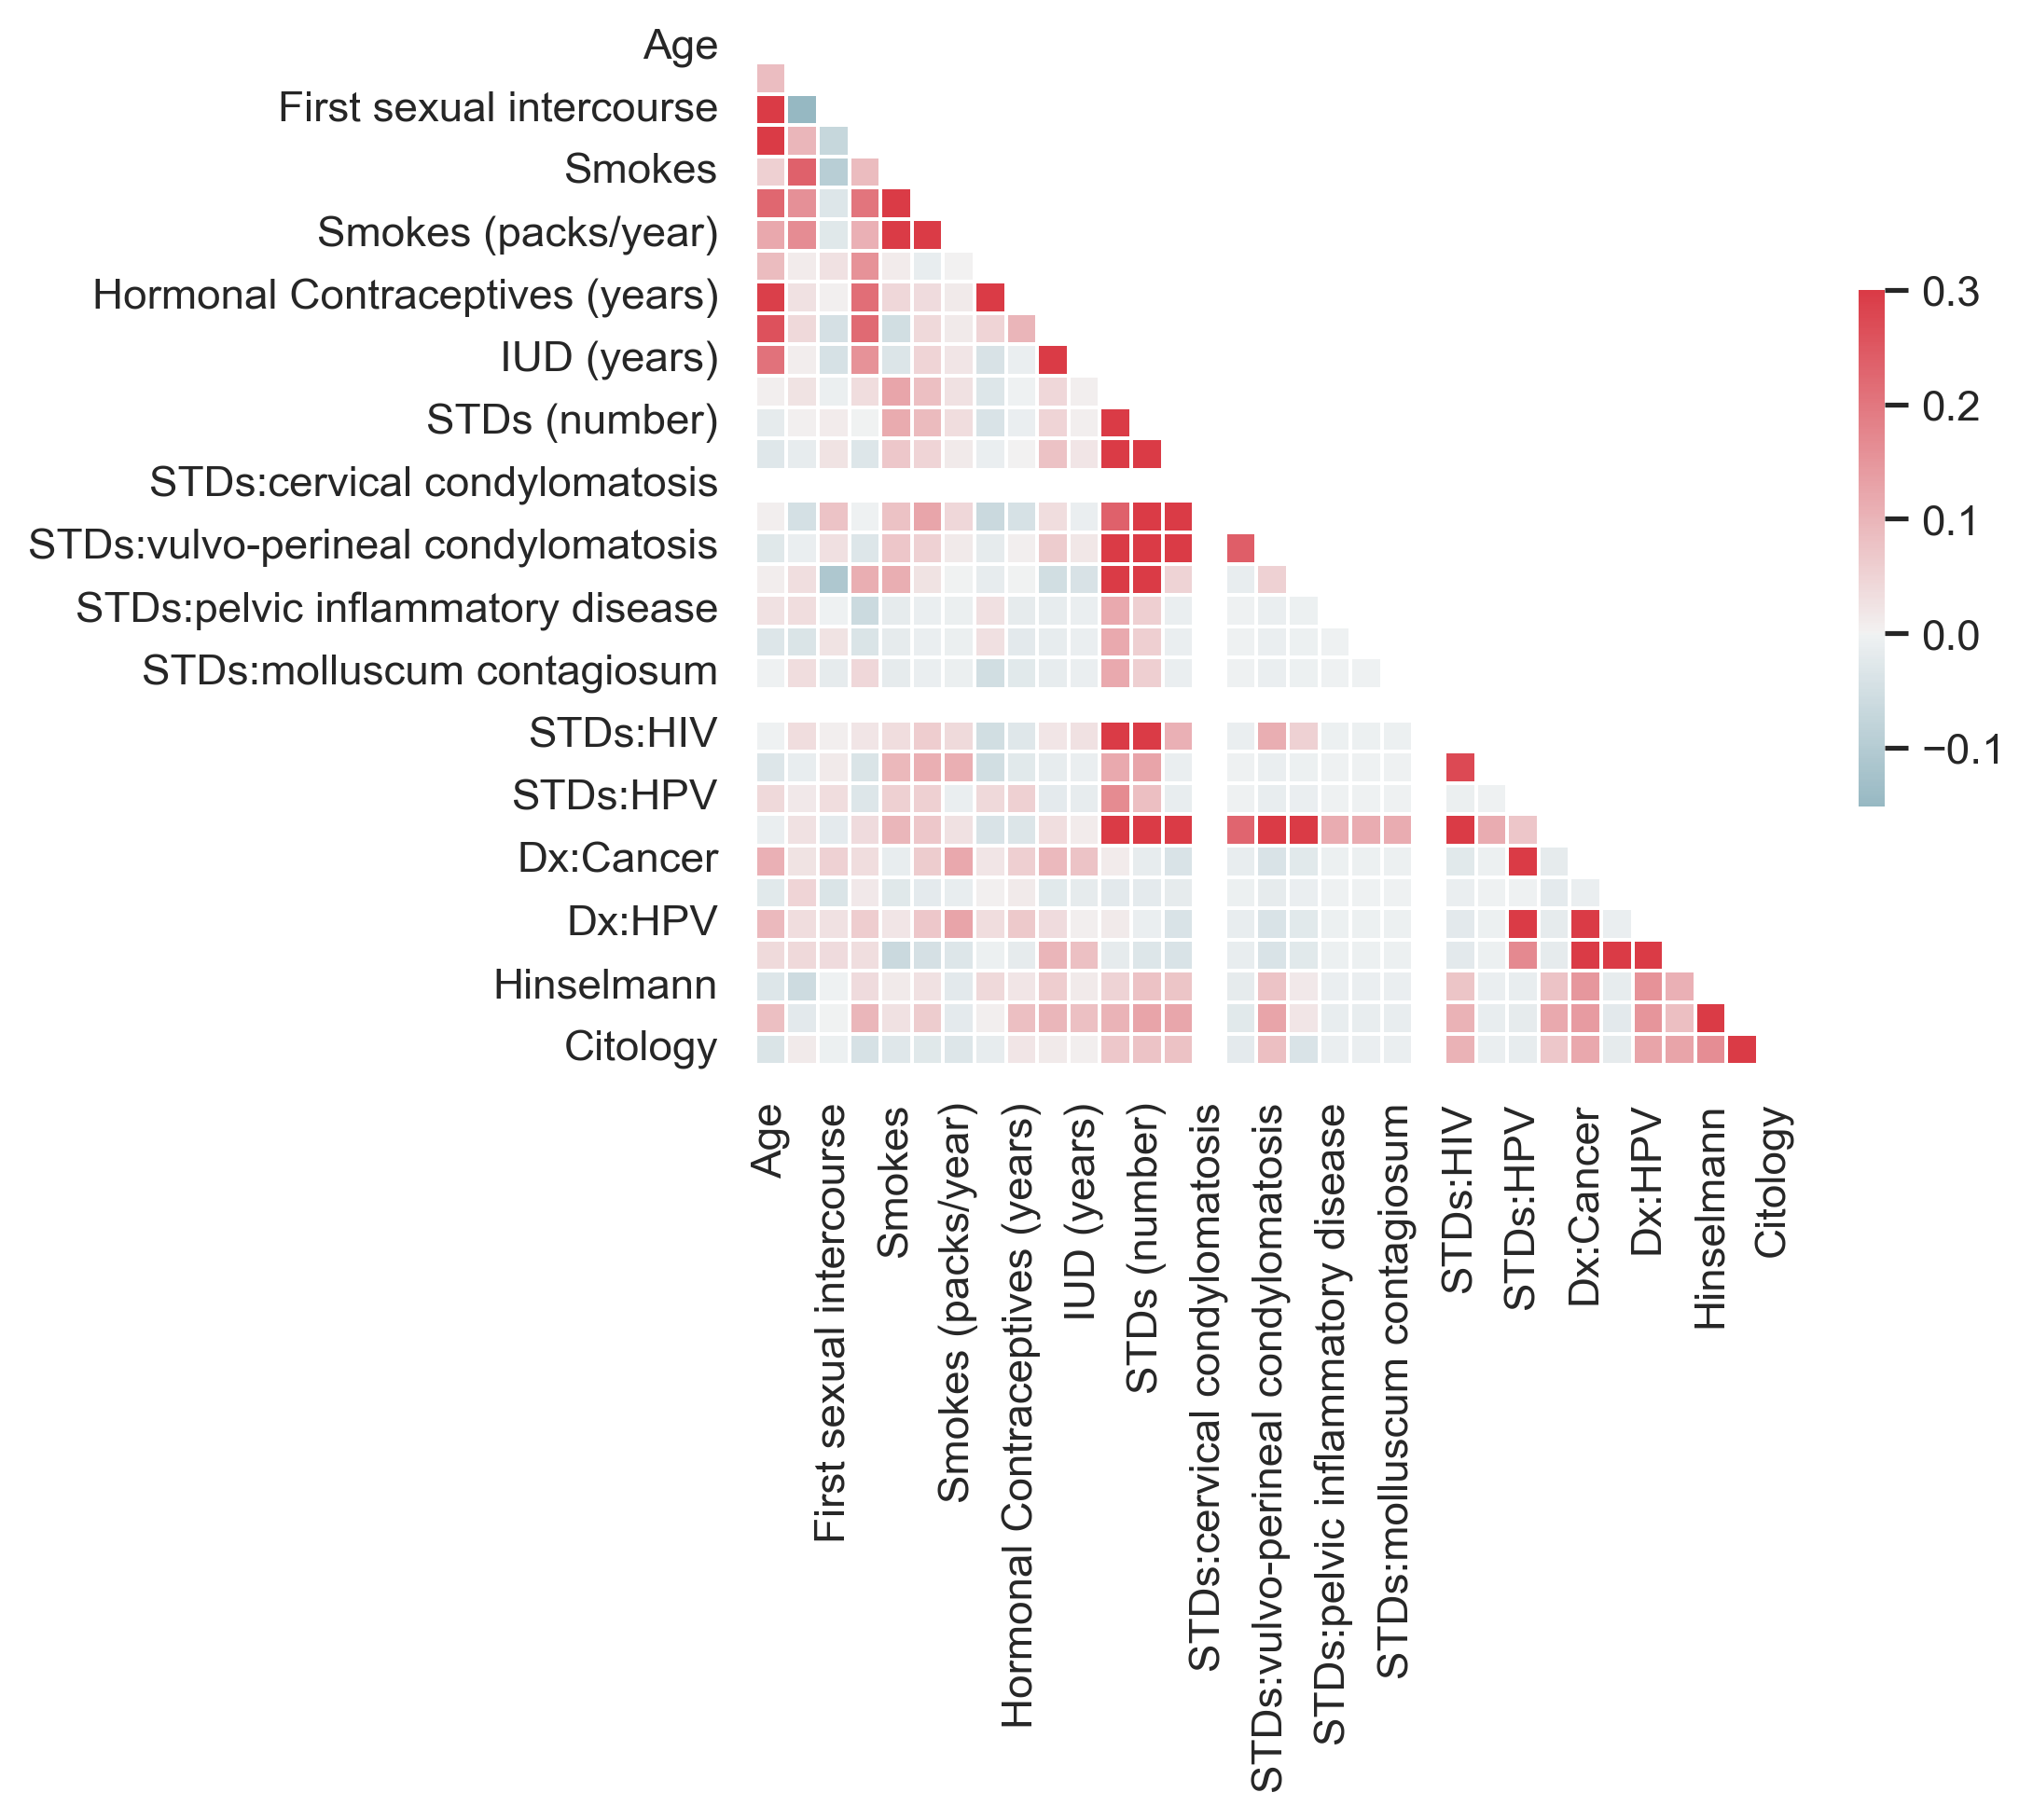

In [78]:
# have a look at the correlations between features
import seaborn as sns
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, 
            vmax= .3, center=0,
            square=True, linewidths=.5, 
            cbar_kws={"shrink": .5});

In [79]:
# Build a (complex) model 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

accuracy_score(y_test,model.predict(X_test))

0.9402985074626866

## Explaining predictions with LIME

In [80]:
# adapt for lime
X = X.to_numpy()
X_train_lime, X_test_lime, y_train_lime, y_test_lime = train_test_split(X, y, test_size=0.3, random_state=42)

# fit model with adapted data
model_lime = RandomForestClassifier(random_state=42)
model_lime.fit(X_train_lime, y_train_lime)

accuracy_score(y_test_lime,model_lime.predict(X_test_lime))

0.9402985074626866

In [81]:
# construct a LIME explainer
from lime.lime_tabular import LimeTabularExplainer

explainer_lime = LimeTabularExplainer(X_train_lime,
                                 feature_names=np.array(df.columns),
                                 class_names=['benign','malignant'],
                                 discretize_continuous=True)

# pick an example for both cases
benign_idx = np.where(y_test_lime == 0)[0][0]
malignant_idx = np.where(y_test_lime == 1)[0][0]

conf1 = model_lime.predict_proba(X_test_lime[benign_idx].reshape(1, -1))[0][0]
conf2 = model_lime.predict_proba(X_test_lime[malignant_idx].reshape(1, -1))[0][0]

print("selected benign sample: %i confidence=%i percent"%(benign_idx, conf1*100))
print("selected malignant sample: %i confidence=%i percent"%(malignant_idx, conf2*100))

selected benign sample: 0 confidence=98 percent
selected malignant sample: 14 confidence=57 percent


In [82]:
# A helper function to display explanations as a plot

def plot_explanation(explanation, label, figsize=(8,5)):
    exp_list = explanation.as_list(label=label)
    fig, ax = plt.subplots(figsize=figsize)
    vals = [x[1] for x in exp_list]
    names = [x[0] for x in exp_list]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(exp_list)) + .5
    ax.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    return fig, ax

(<Figure size 2400x1500 with 1 Axes>, <Axes: >)

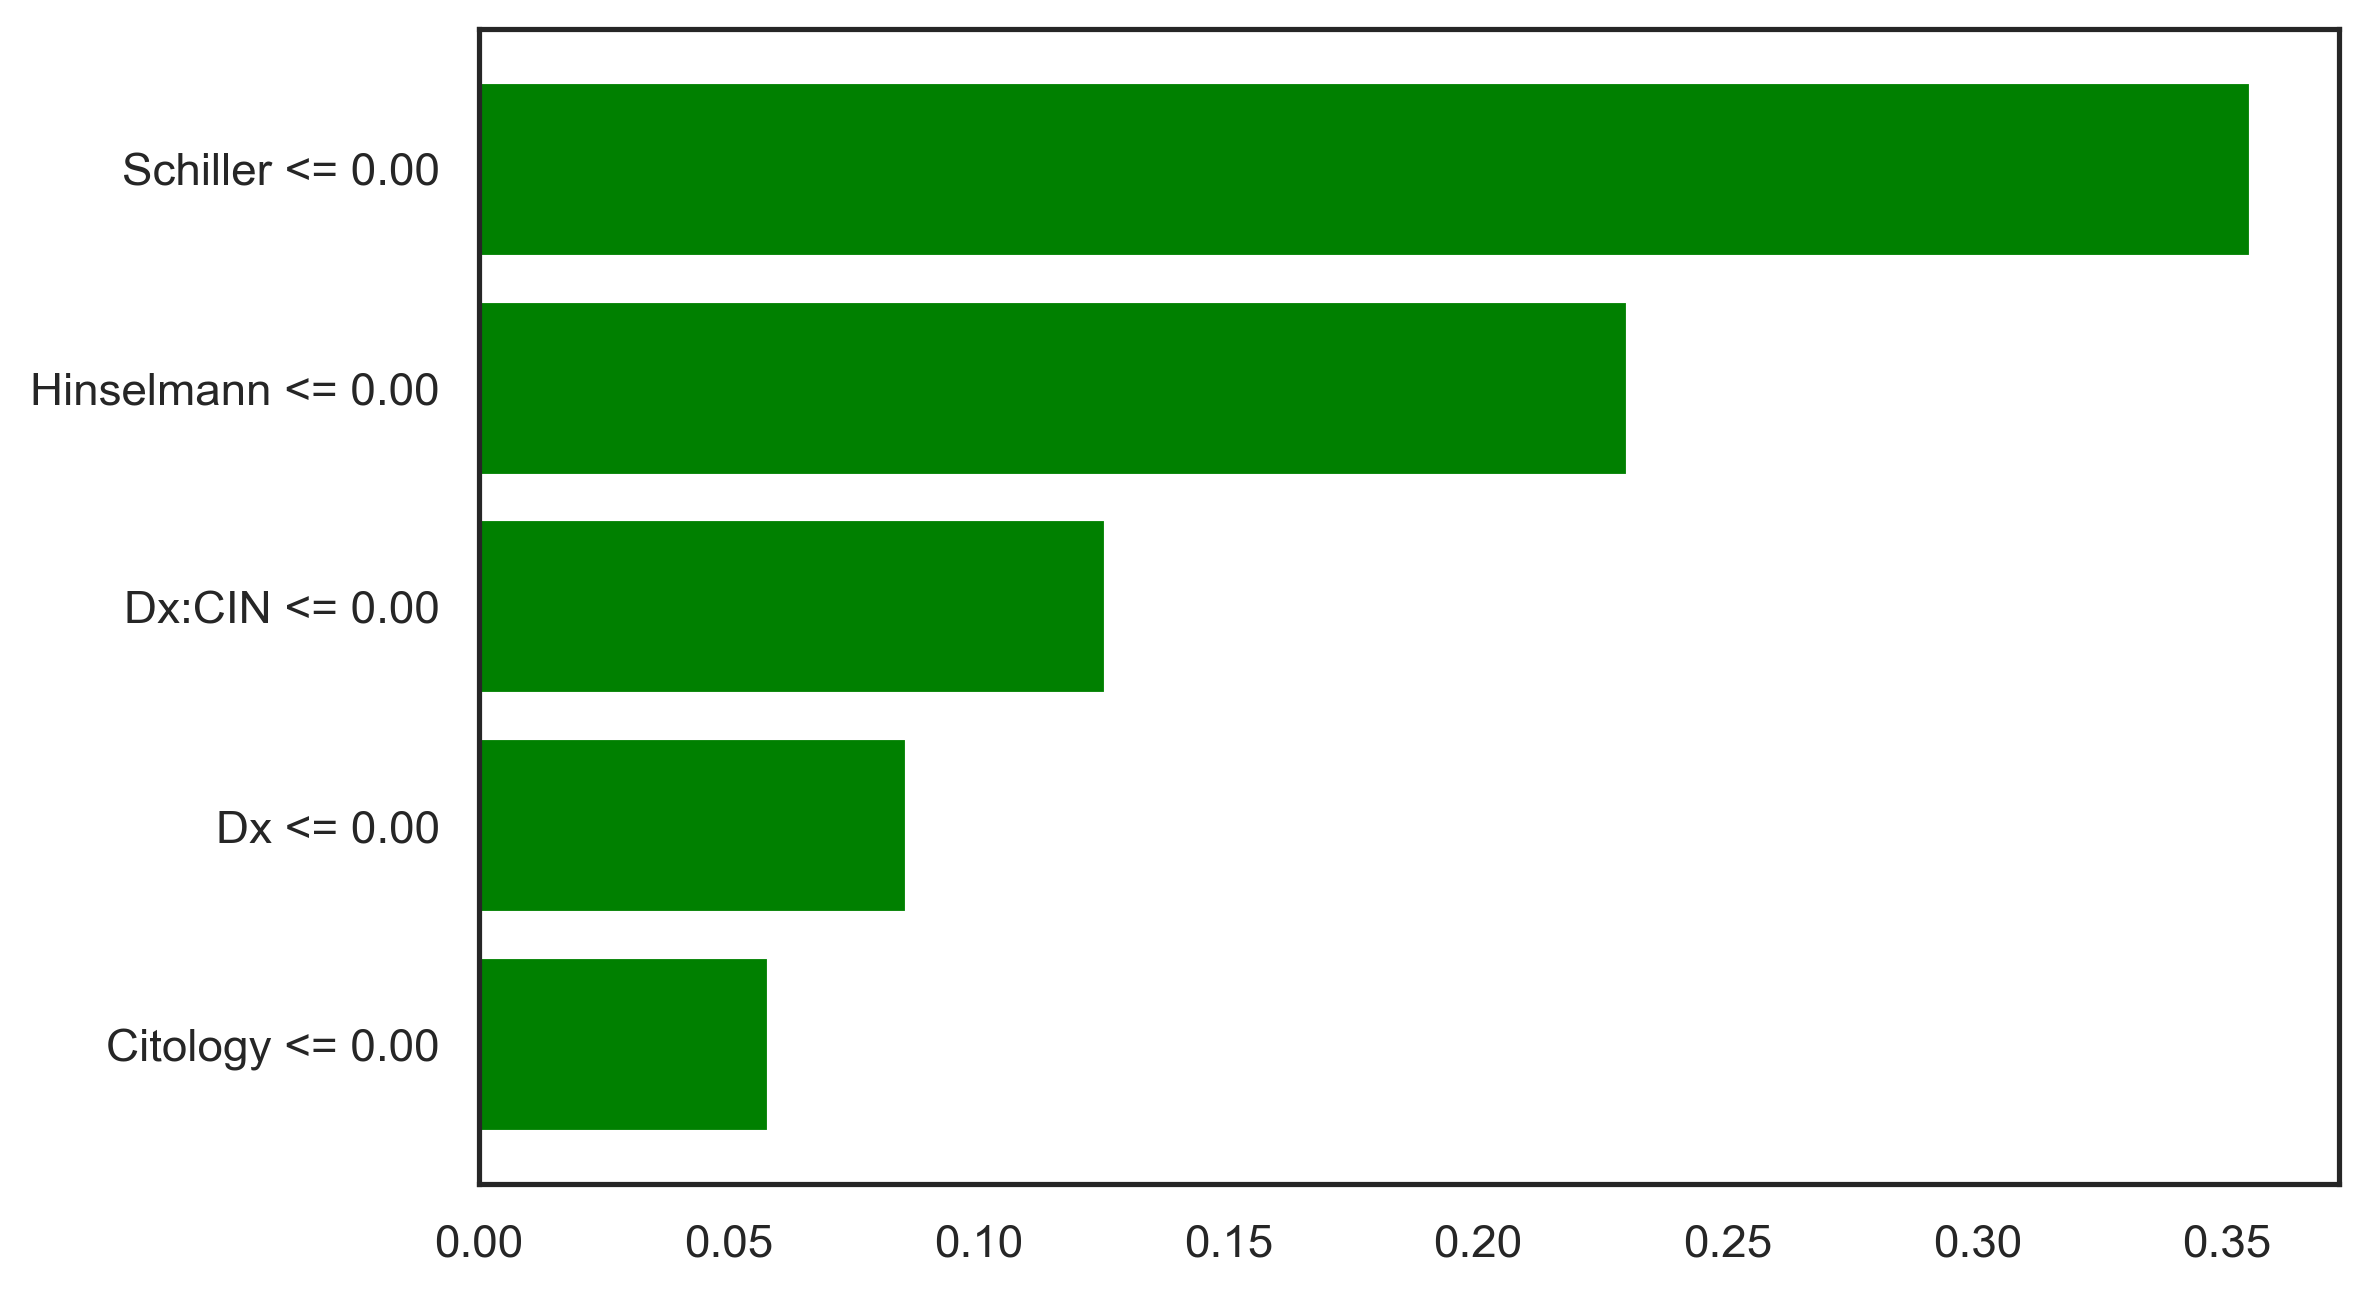

In [83]:
# See the explanation for the benign case
explanation = explainer_lime.explain_instance(X_test_lime[benign_idx],
                                         model_lime.predict_proba,
                                         num_features=5,
                                         labels=[0, 1]) # Request explanations for both classes
plot_explanation(explanation,label=0) #get explanation why prediction is 0, i.e. benign

(<Figure size 2400x1500 with 1 Axes>, <Axes: >)

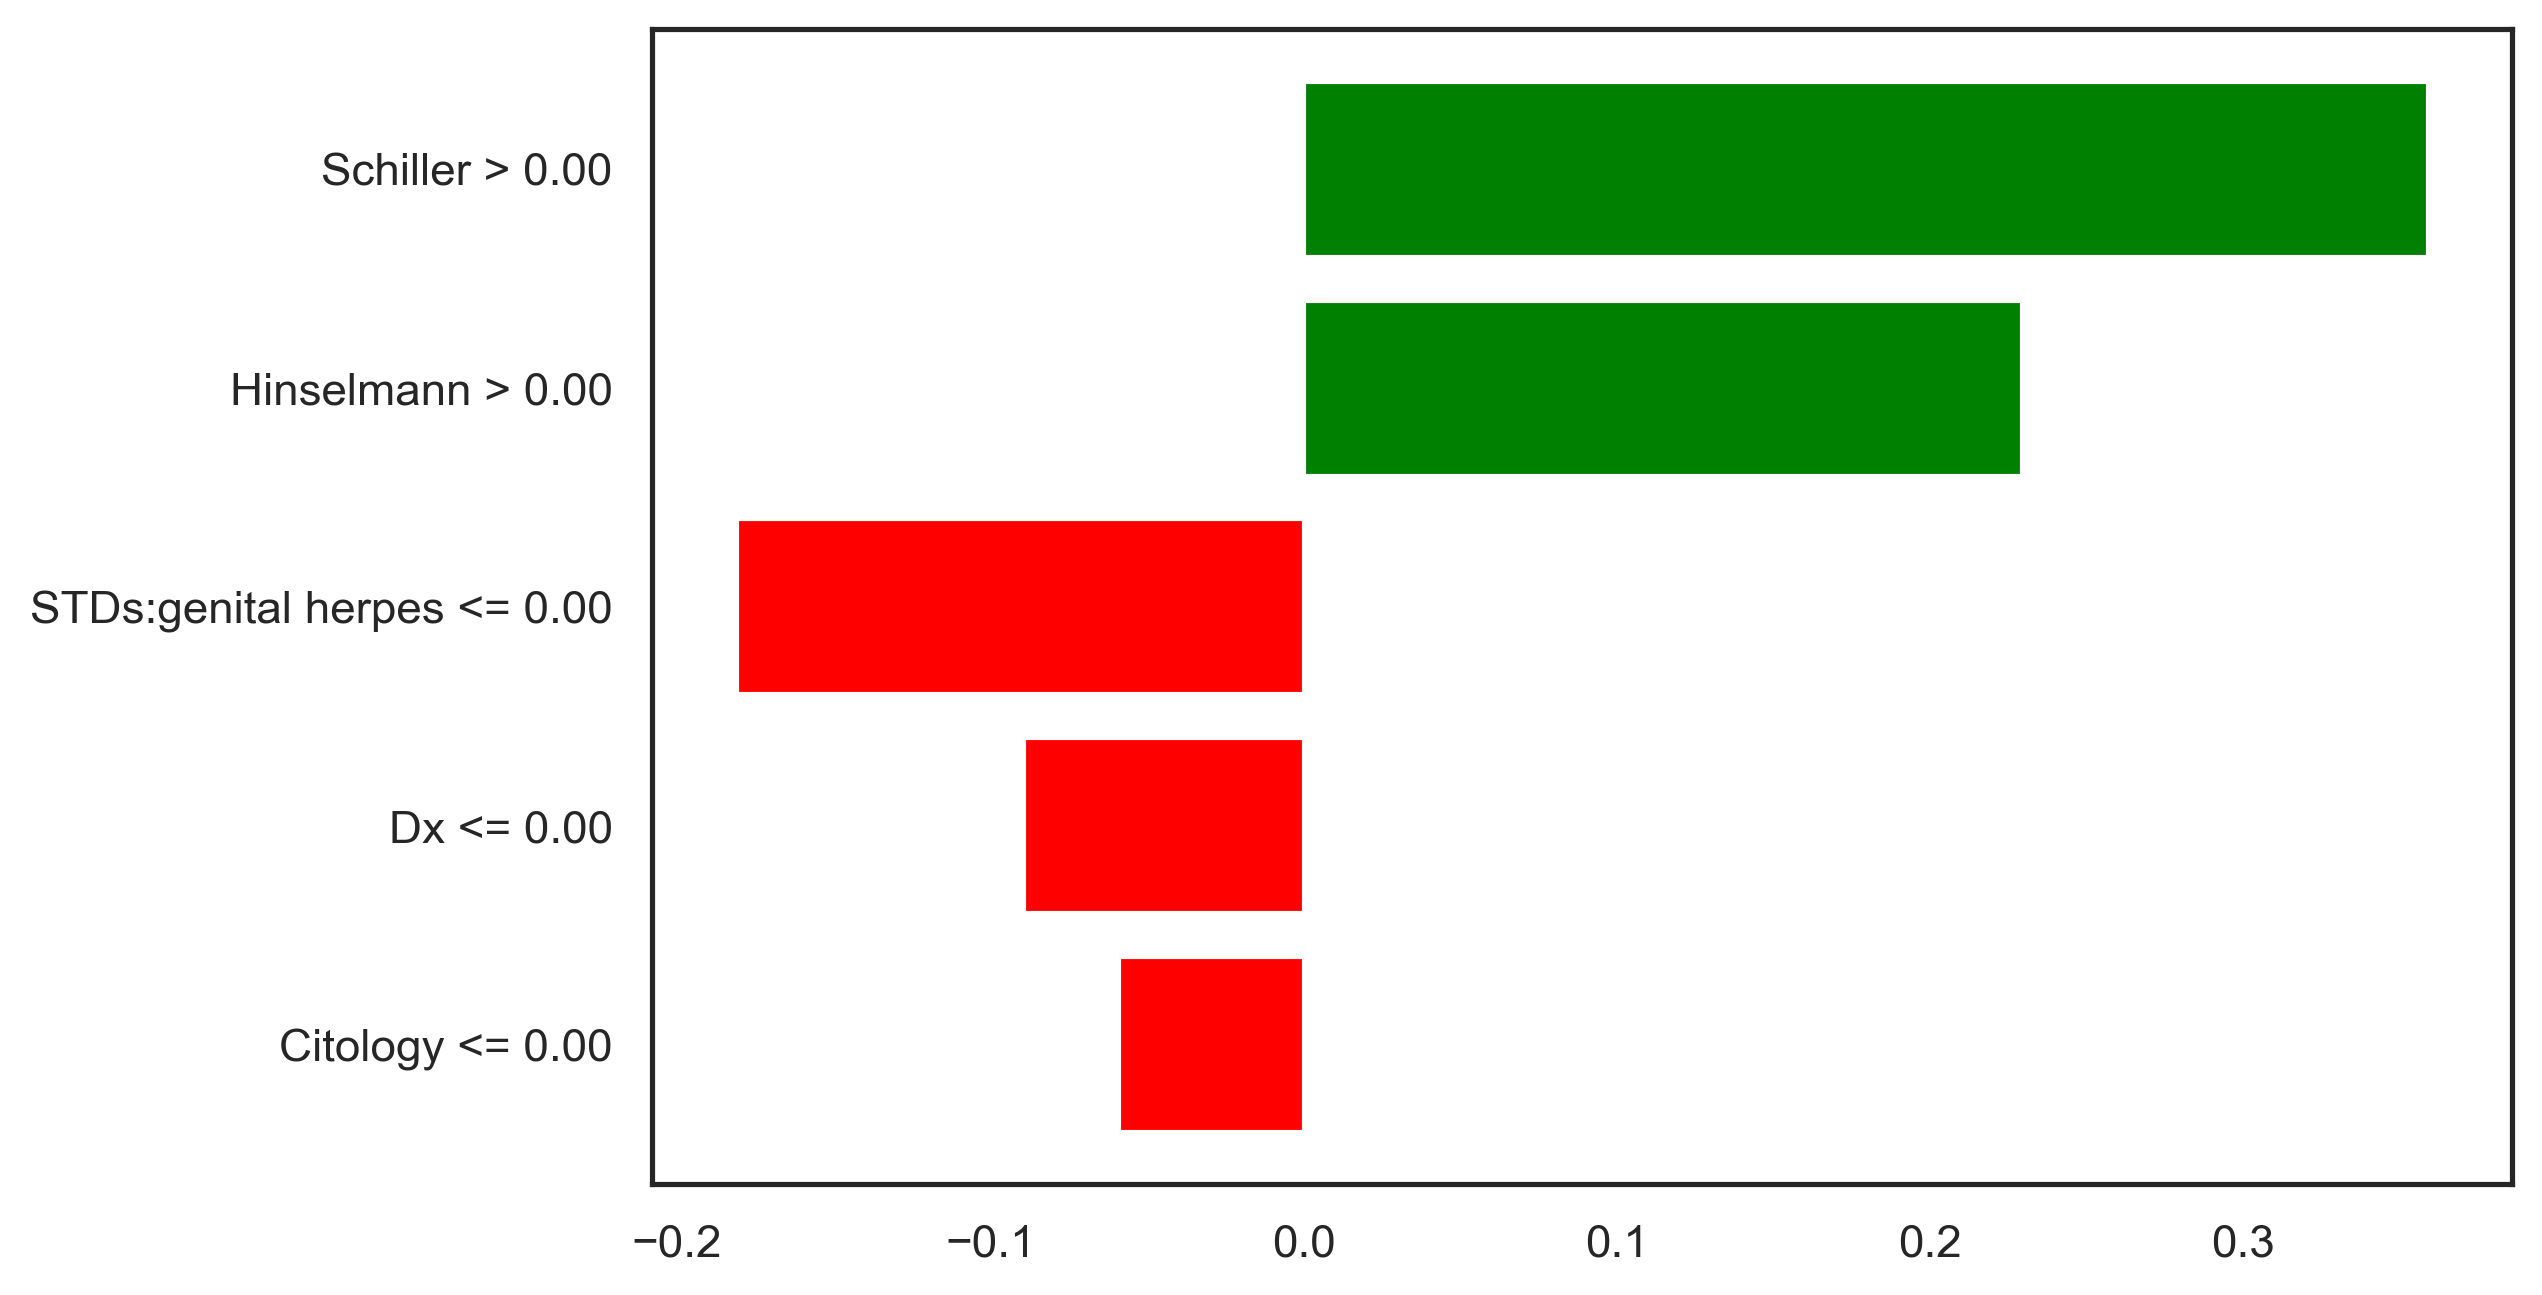

In [84]:
# See the explanation for the malignant case
explanation = explainer_lime.explain_instance(X_test_lime[malignant_idx],
                                         model_lime.predict_proba,
                                         num_features=5,
                                         labels=[0, 1]) # Request explanations for both classes
plot_explanation(explanation,label=1) #get explanation why prediction is 1, i.e. malignant

## Explaining predictions with SHAP
Read more at https://shap.readthedocs.io/en/latest/

In [163]:
import xgboost
import shap
shap.plots.initjs()
#define and train model
model = xgboost.XGBClassifier().fit(X_train, y_train) 
#define an explainer
explainer = shap.TreeExplainer(model)
#calculate shap values on the test dataset
shap_values = explainer(X_test)

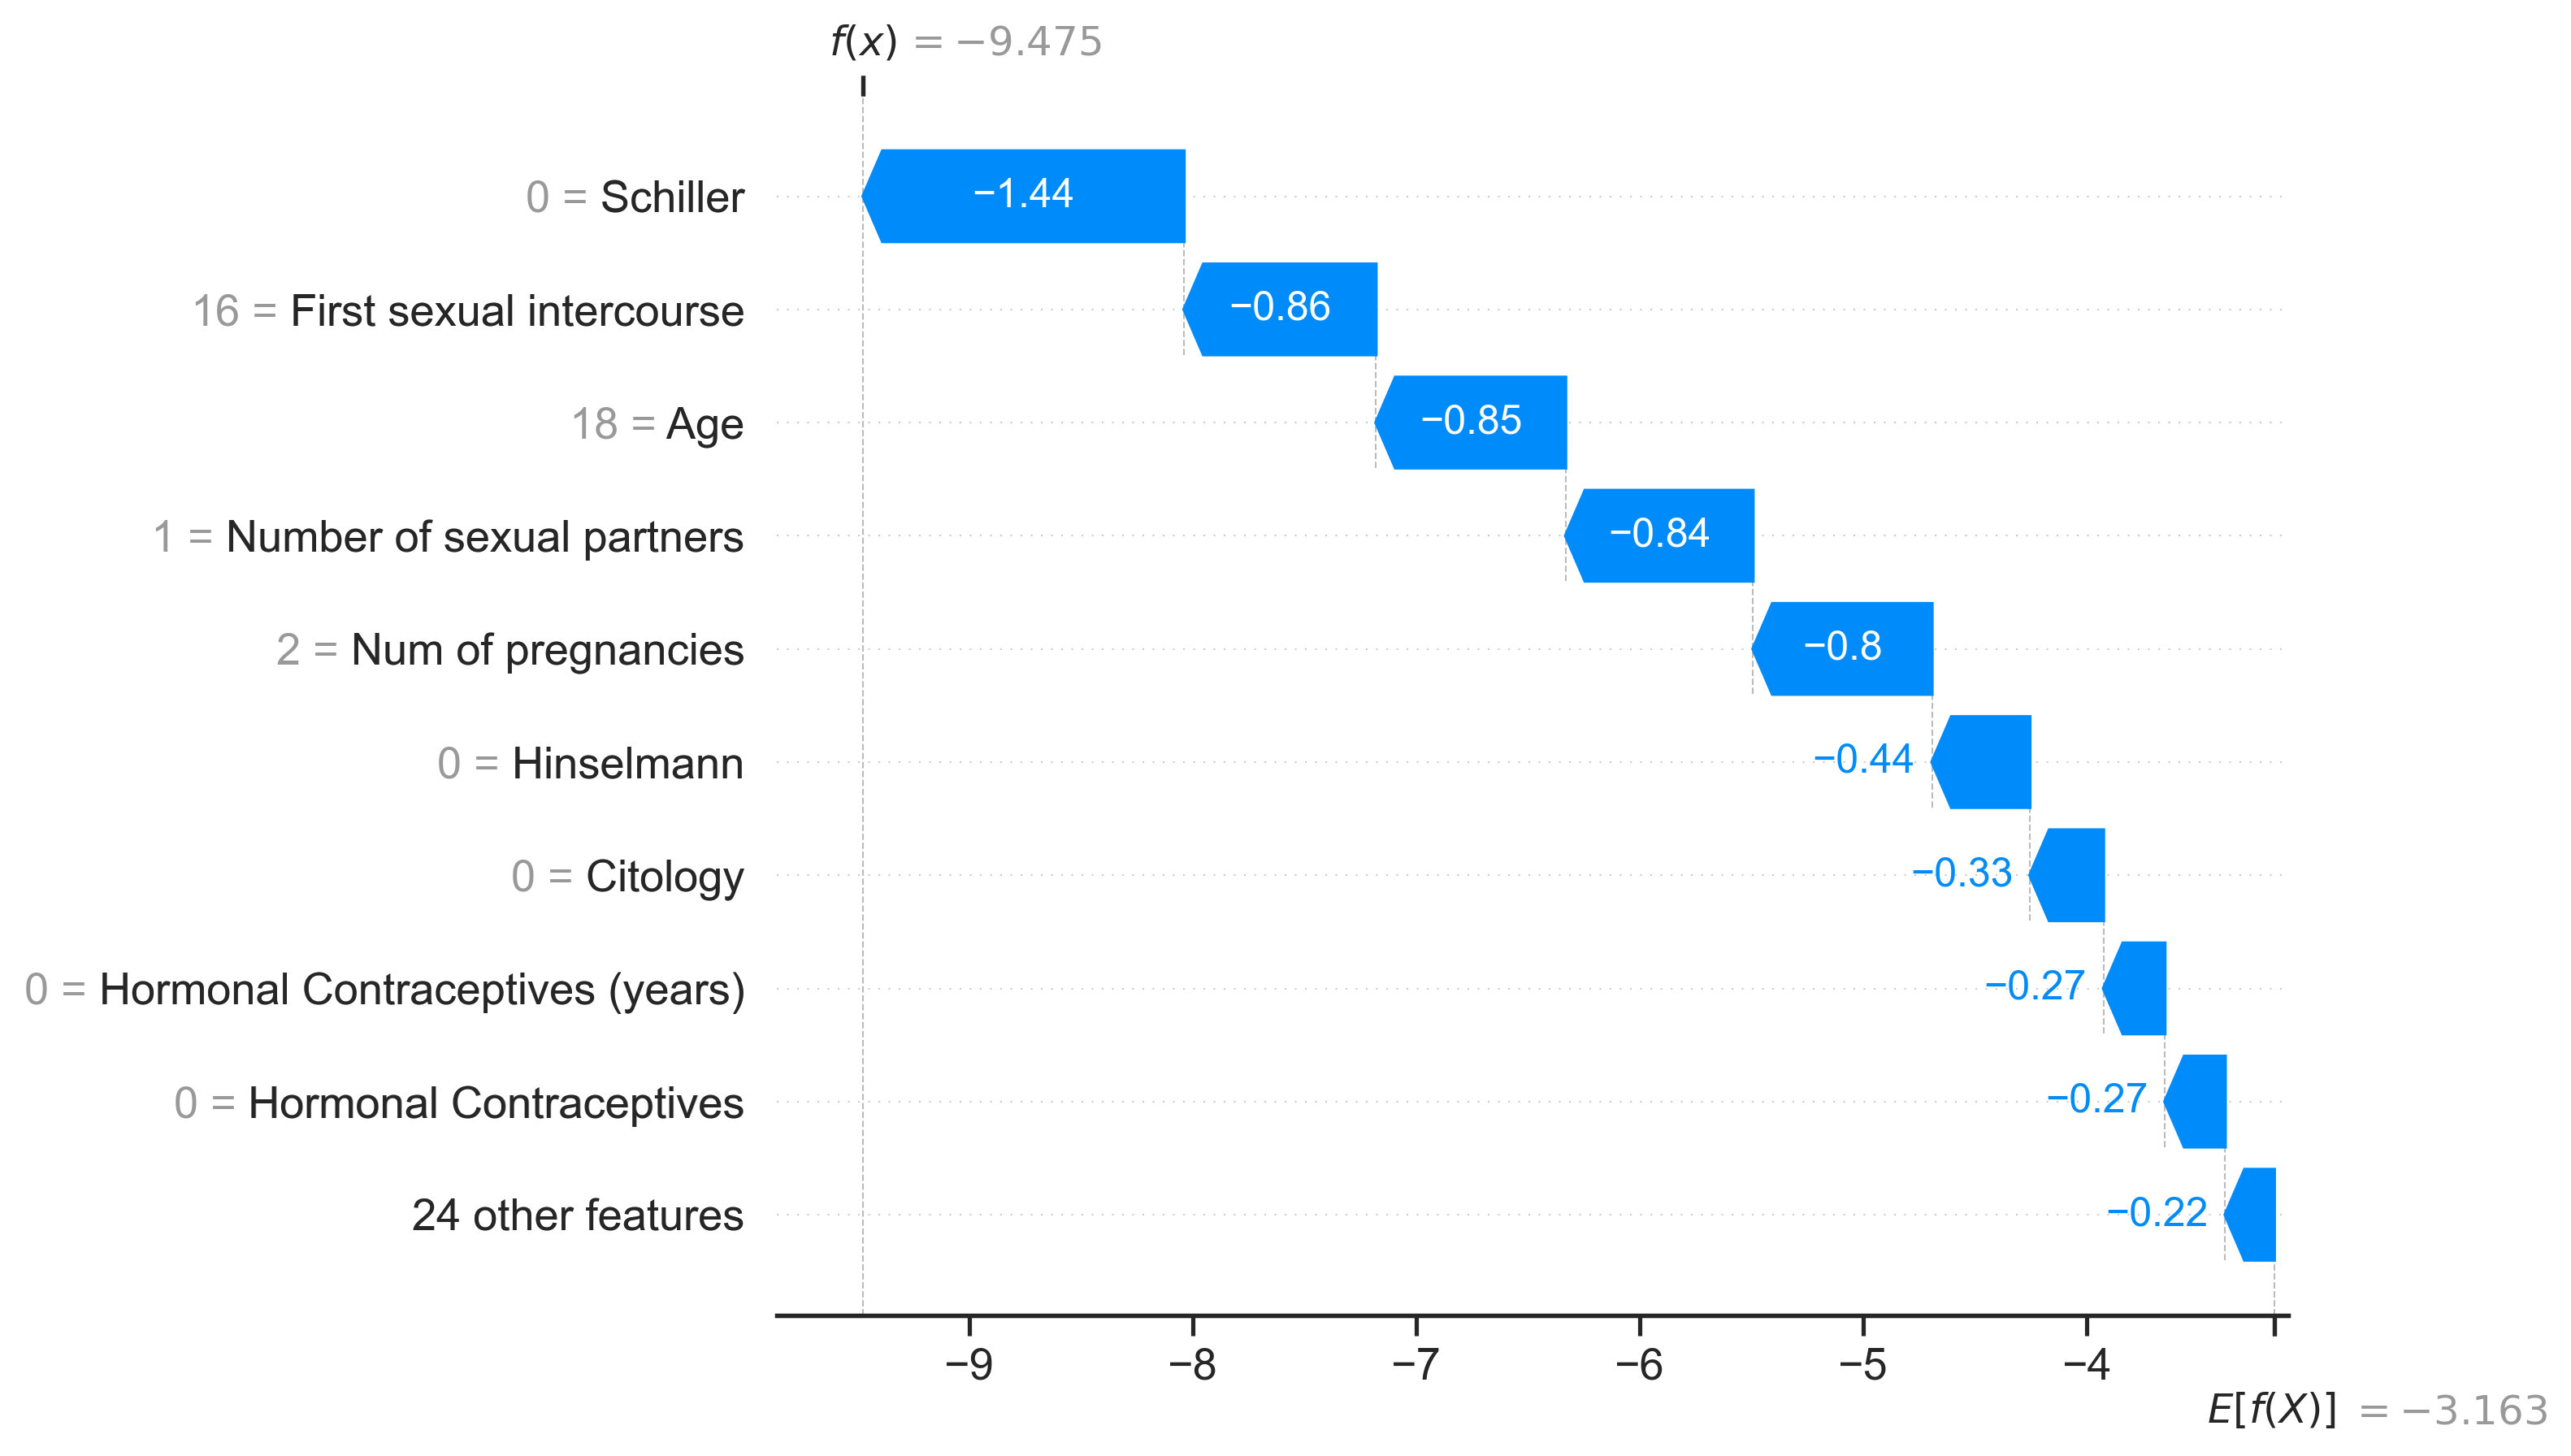

In [164]:
#Waterfall plot shows you the contribution of individual features to the prediction for a benign observation
shap.plots.waterfall(shap_values[benign_idx])

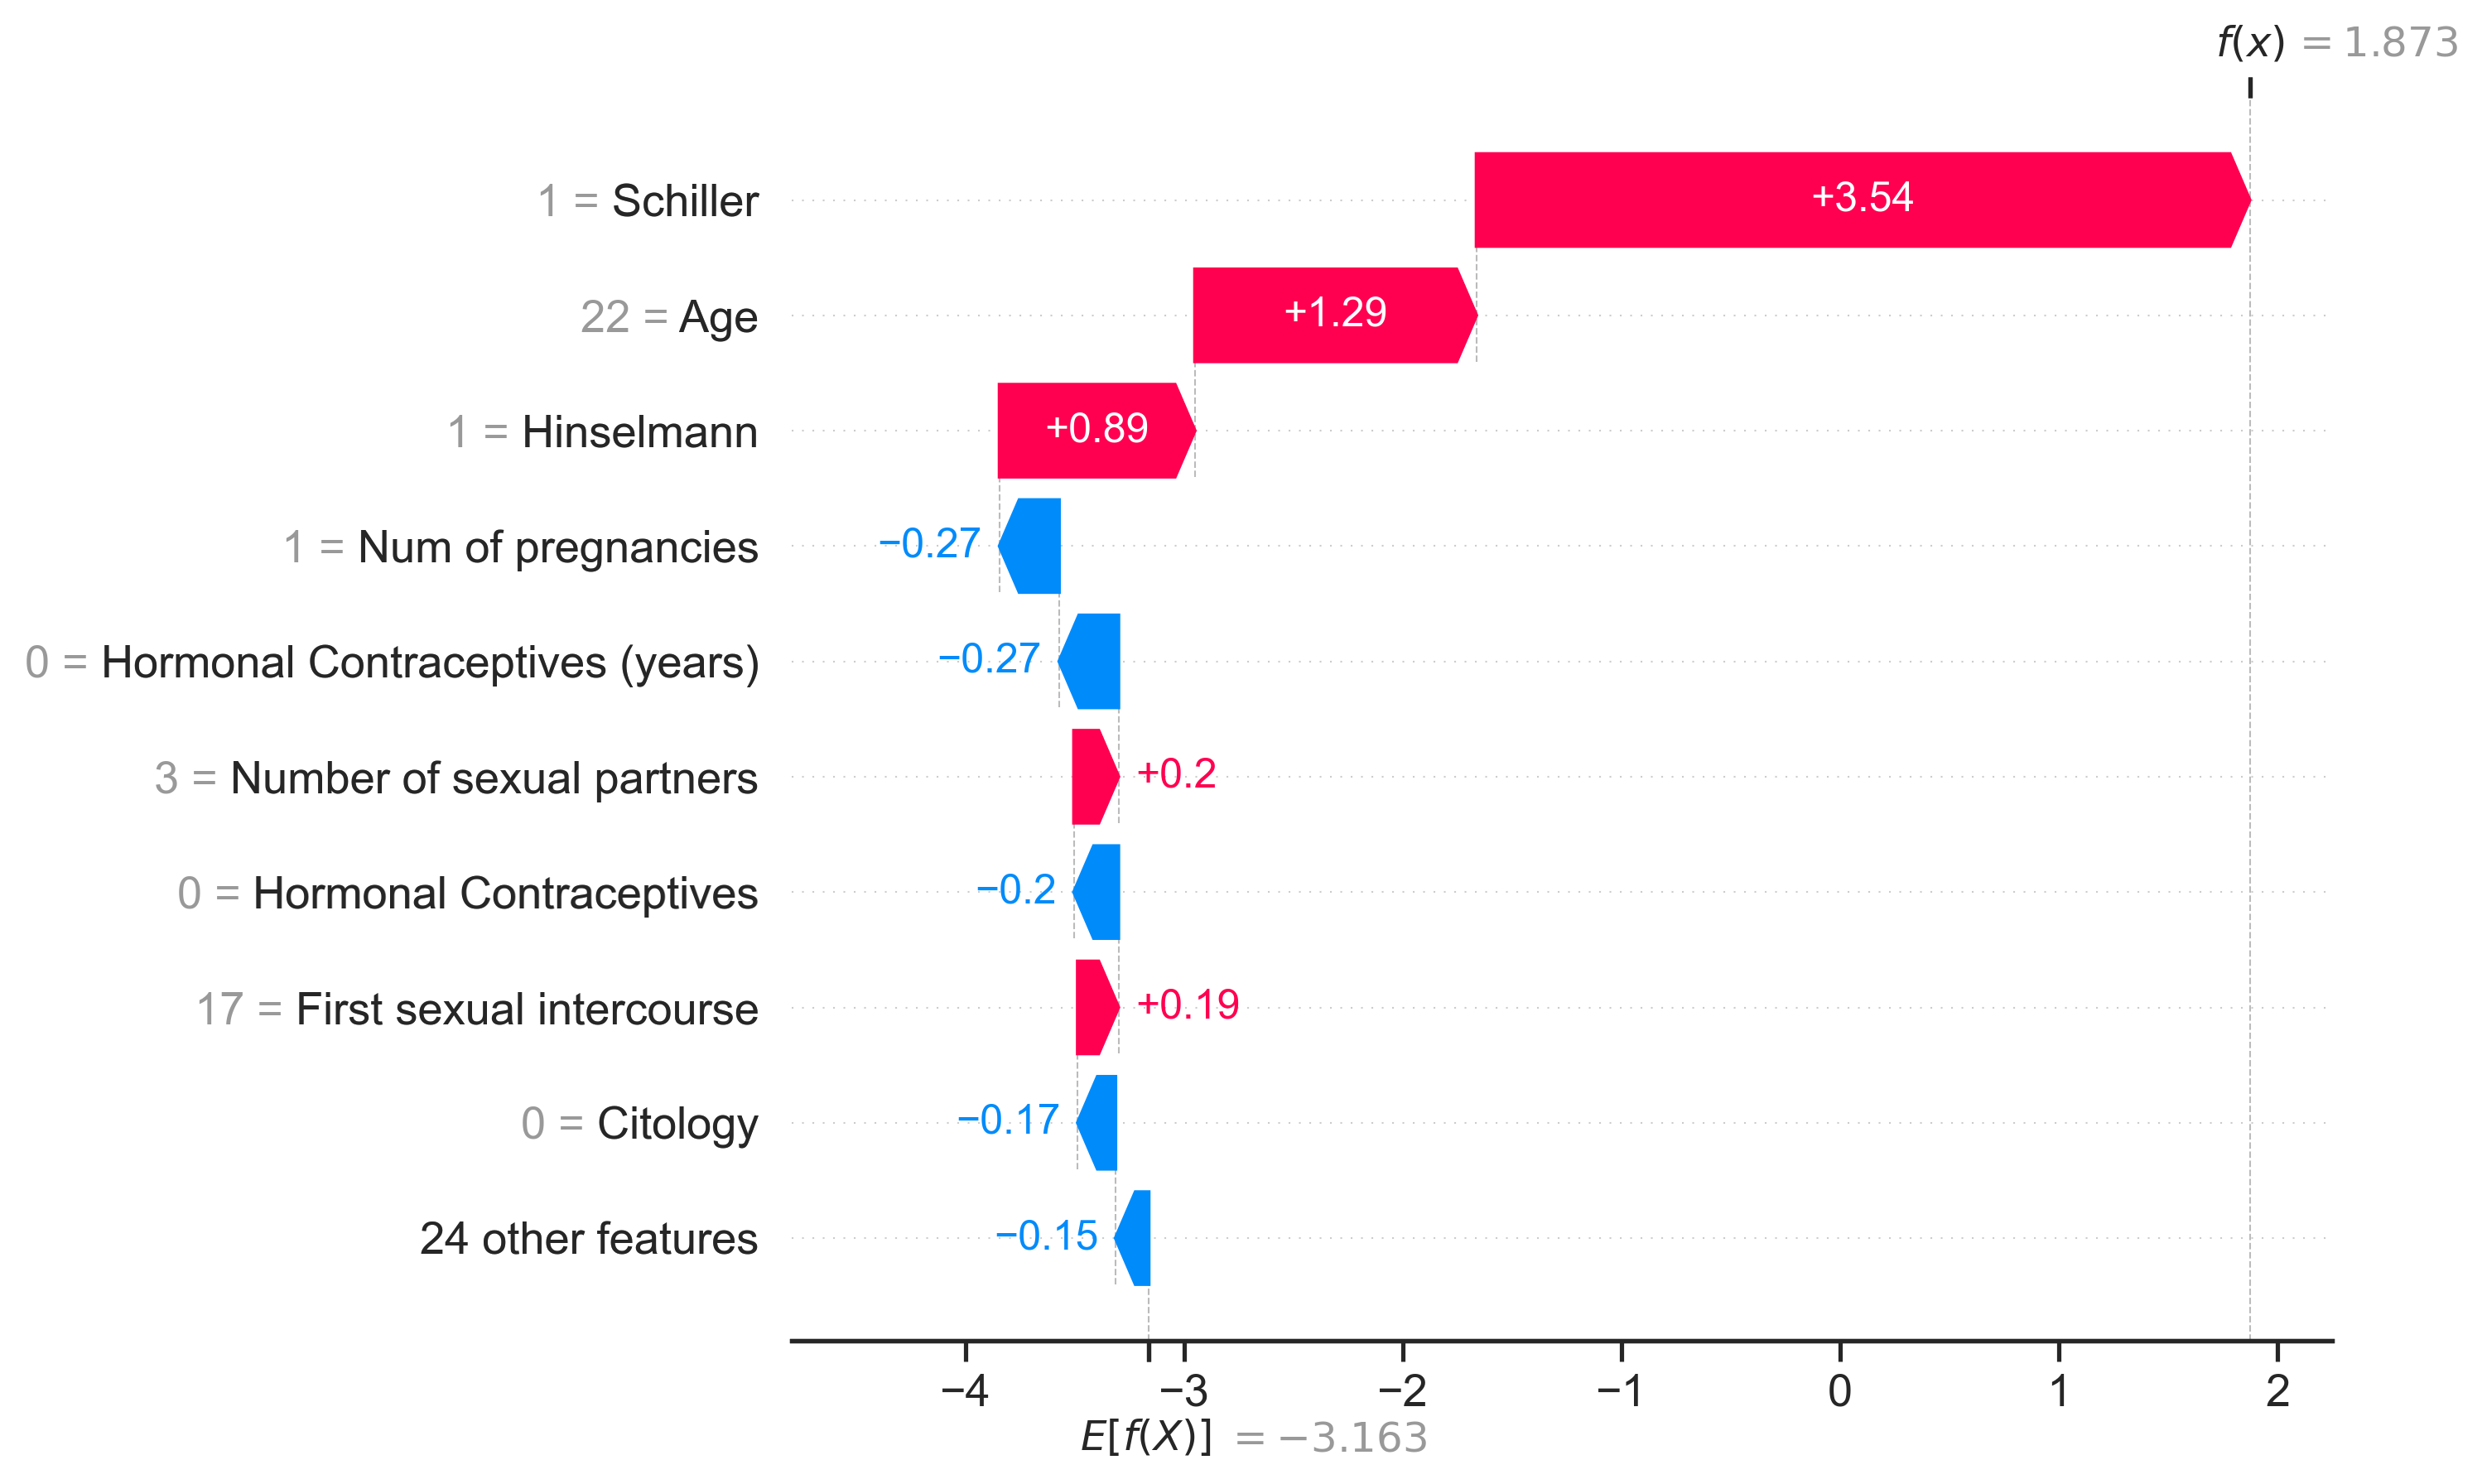

In [165]:
#Waterfall plot shows you the contribution of individual features to the prediction for a malignant observation
shap.plots.waterfall(shap_values[malignant_idx])

In [166]:
#Force Plot is a compressed version of the Waterfall plot
shap.plots.force(shap_values[benign_idx])

In [139]:
#Force Plot is a compressed version of the Waterfall plot
shap.plots.force(shap_values[malignant_idx])

In [167]:
#stacked forceplot for multiple observations (here for all observations in the test dataset)
shap.plots.force(shap_values)

In [168]:
#stacked forceplot for multiple observations (here for all benign cases in the test dataset)
shap.plots.force(shap_values[np.where(y_test_lime == 0)[0]])

In [169]:
#stacked forceplot for multiple observations (here for all malignant cases in the test dataset)
shap.plots.force(shap_values[np.where(y_test_lime == 1)[0]])

### Explaining predictions with SHAP and Random Forest

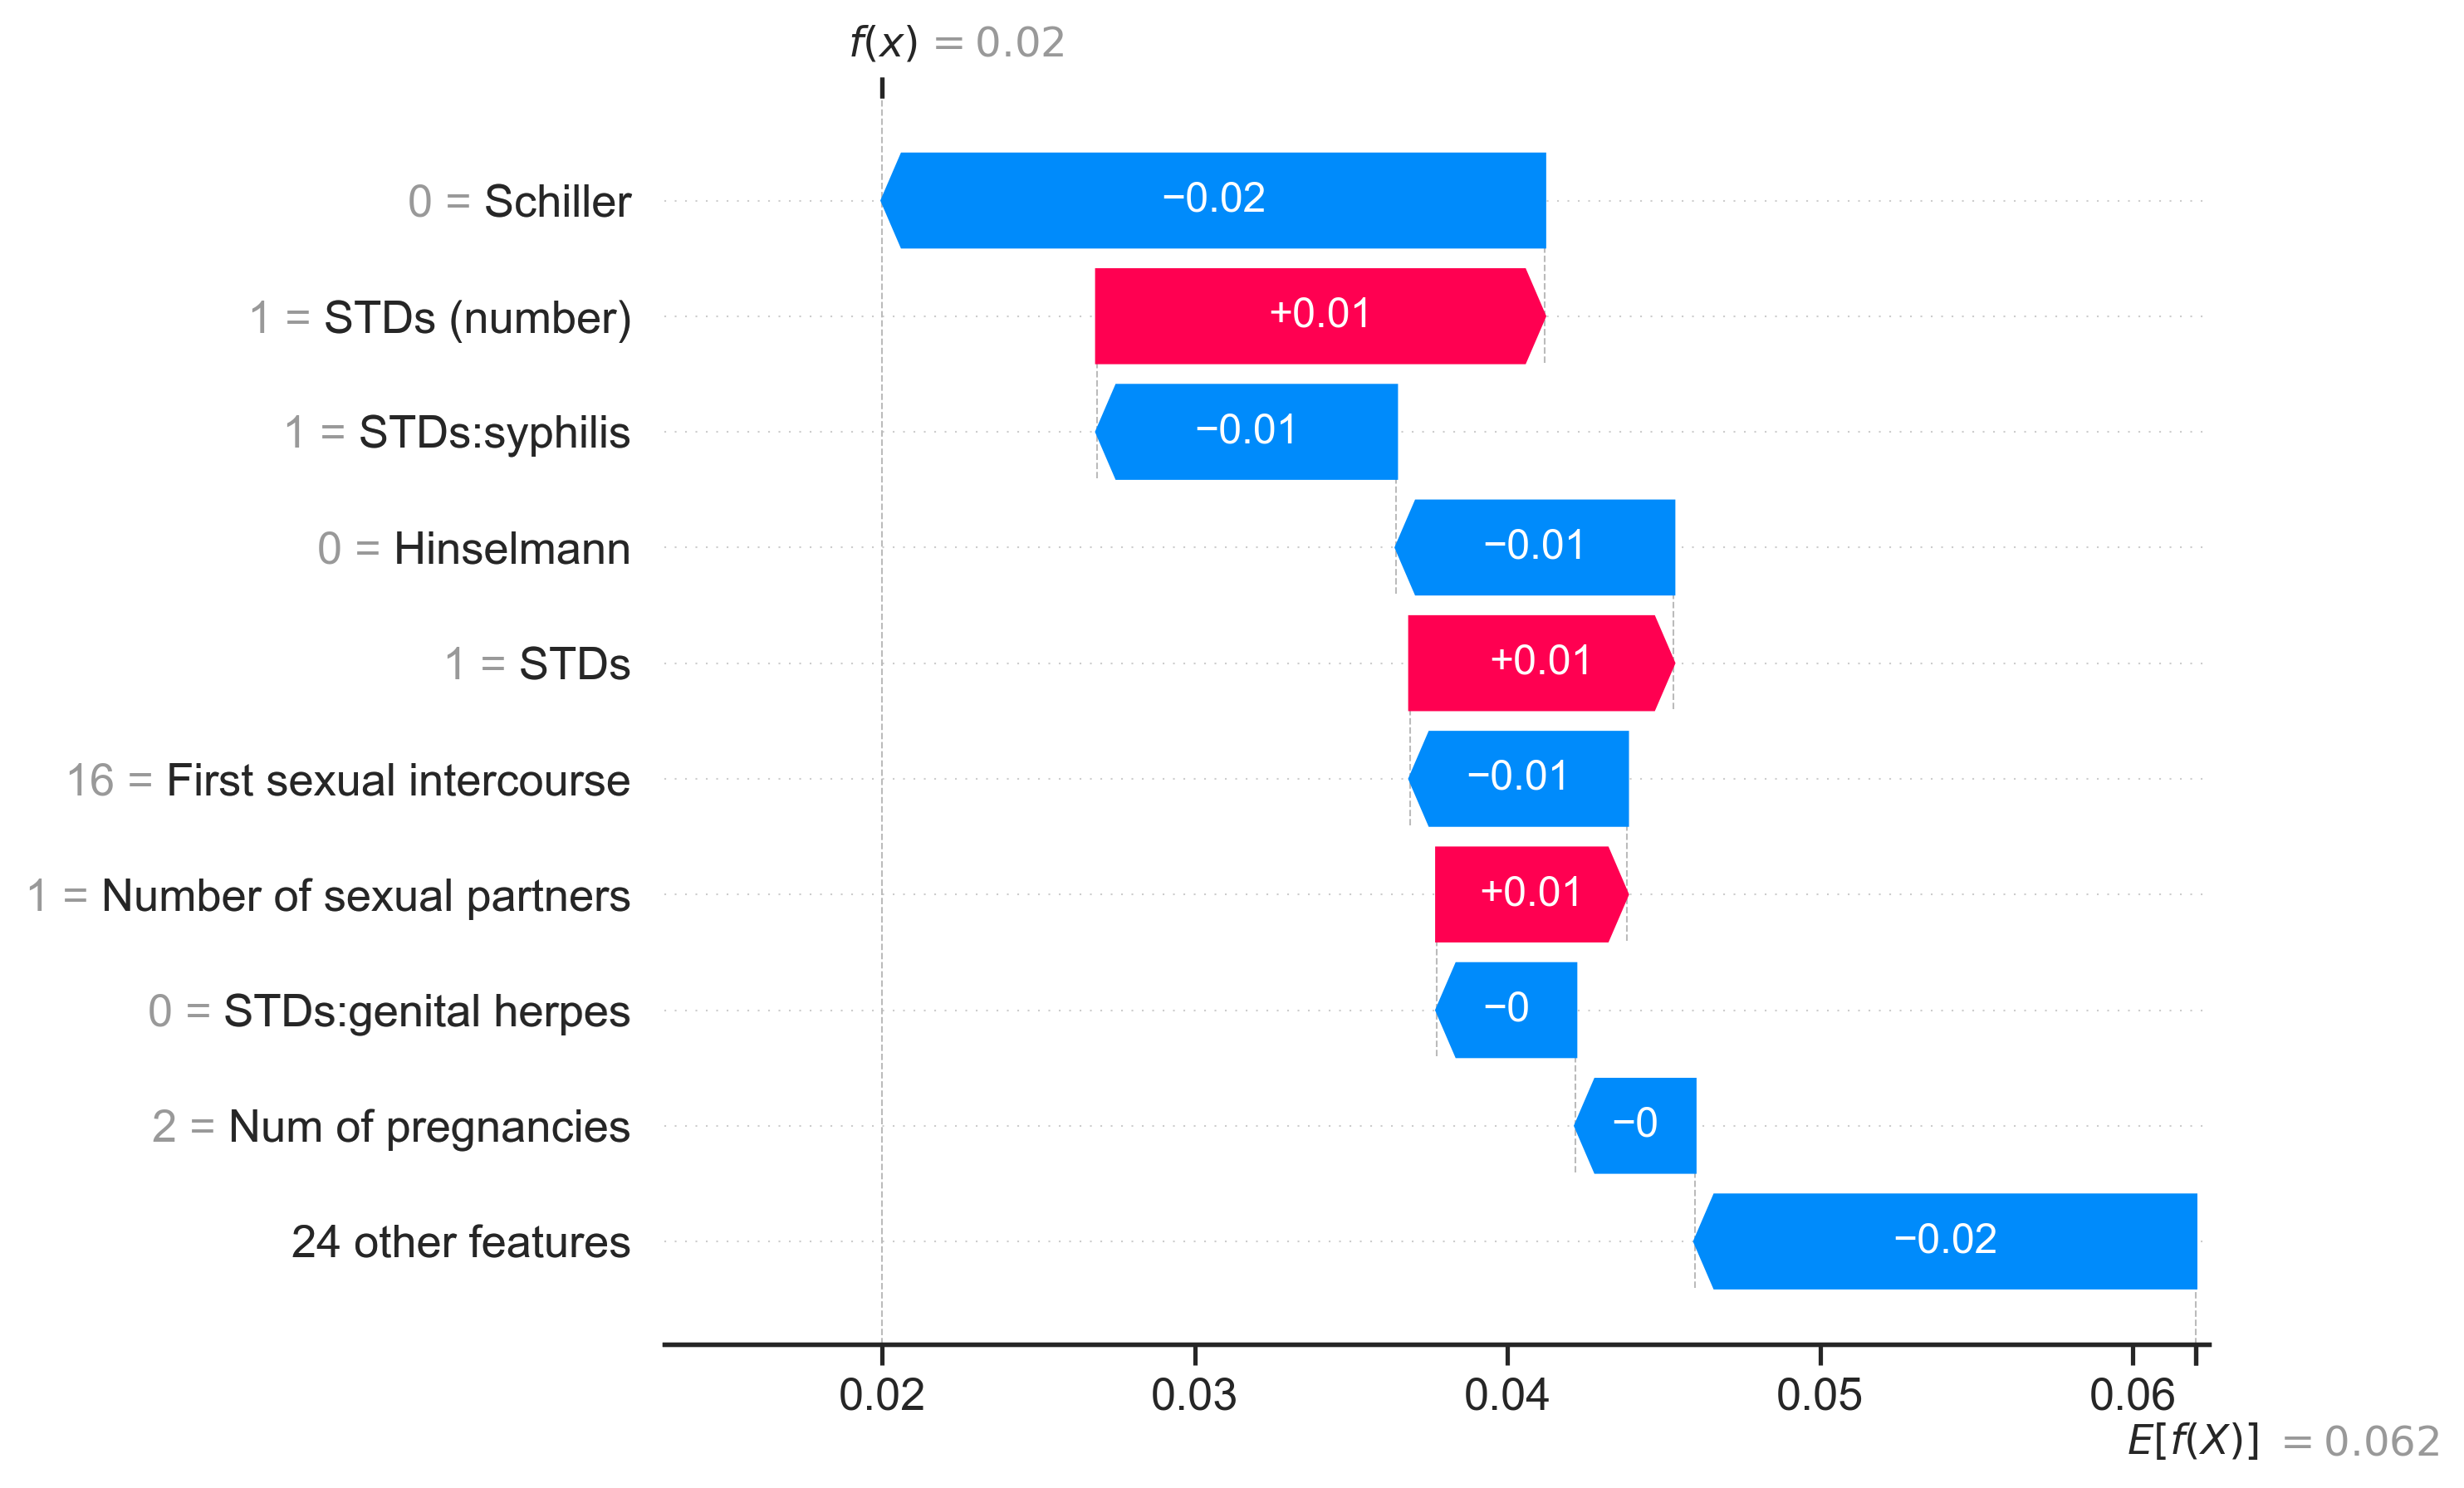

In [141]:
#shap values for Random Forest
model = RandomForestClassifier(random_state=42,)
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)[:,:,1]

shap.plots.waterfall(shap_values[benign_idx])

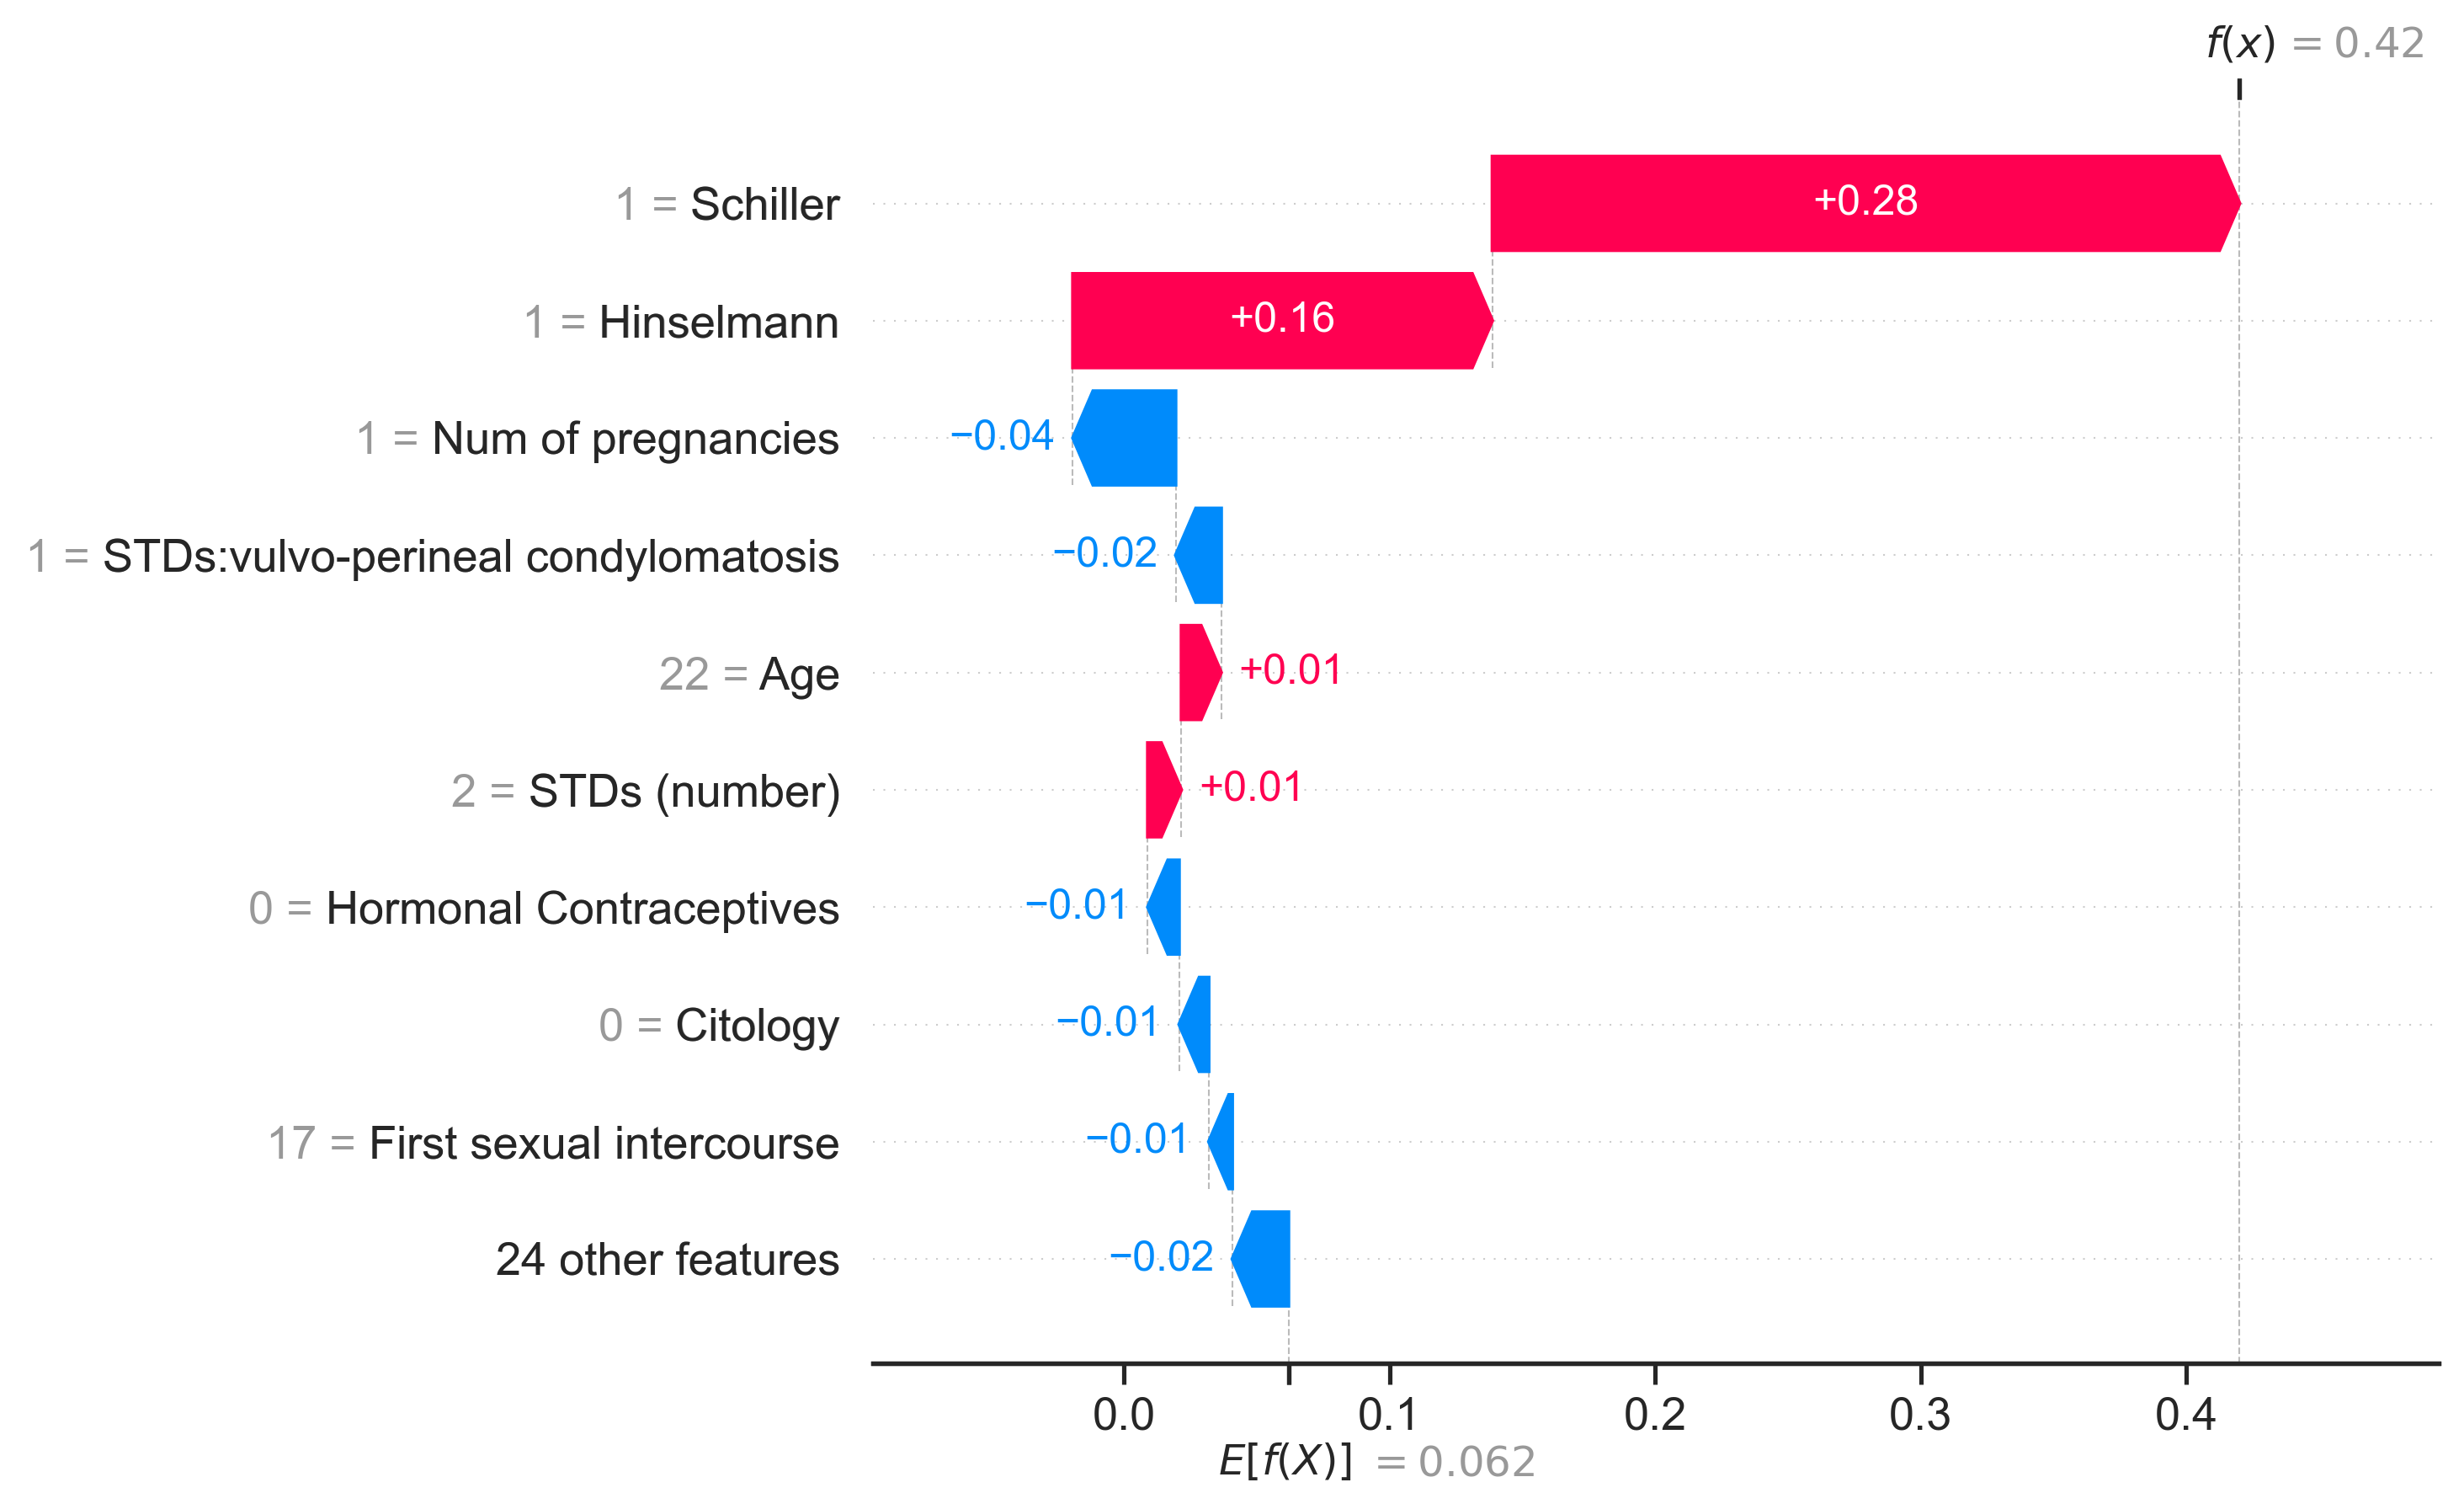

In [156]:
shap.plots.waterfall(shap_values[malignant_idx])

In [143]:
shap.plots.force(shap_values[benign_idx])

In [144]:
shap.plots.force(shap_values[malignant_idx])

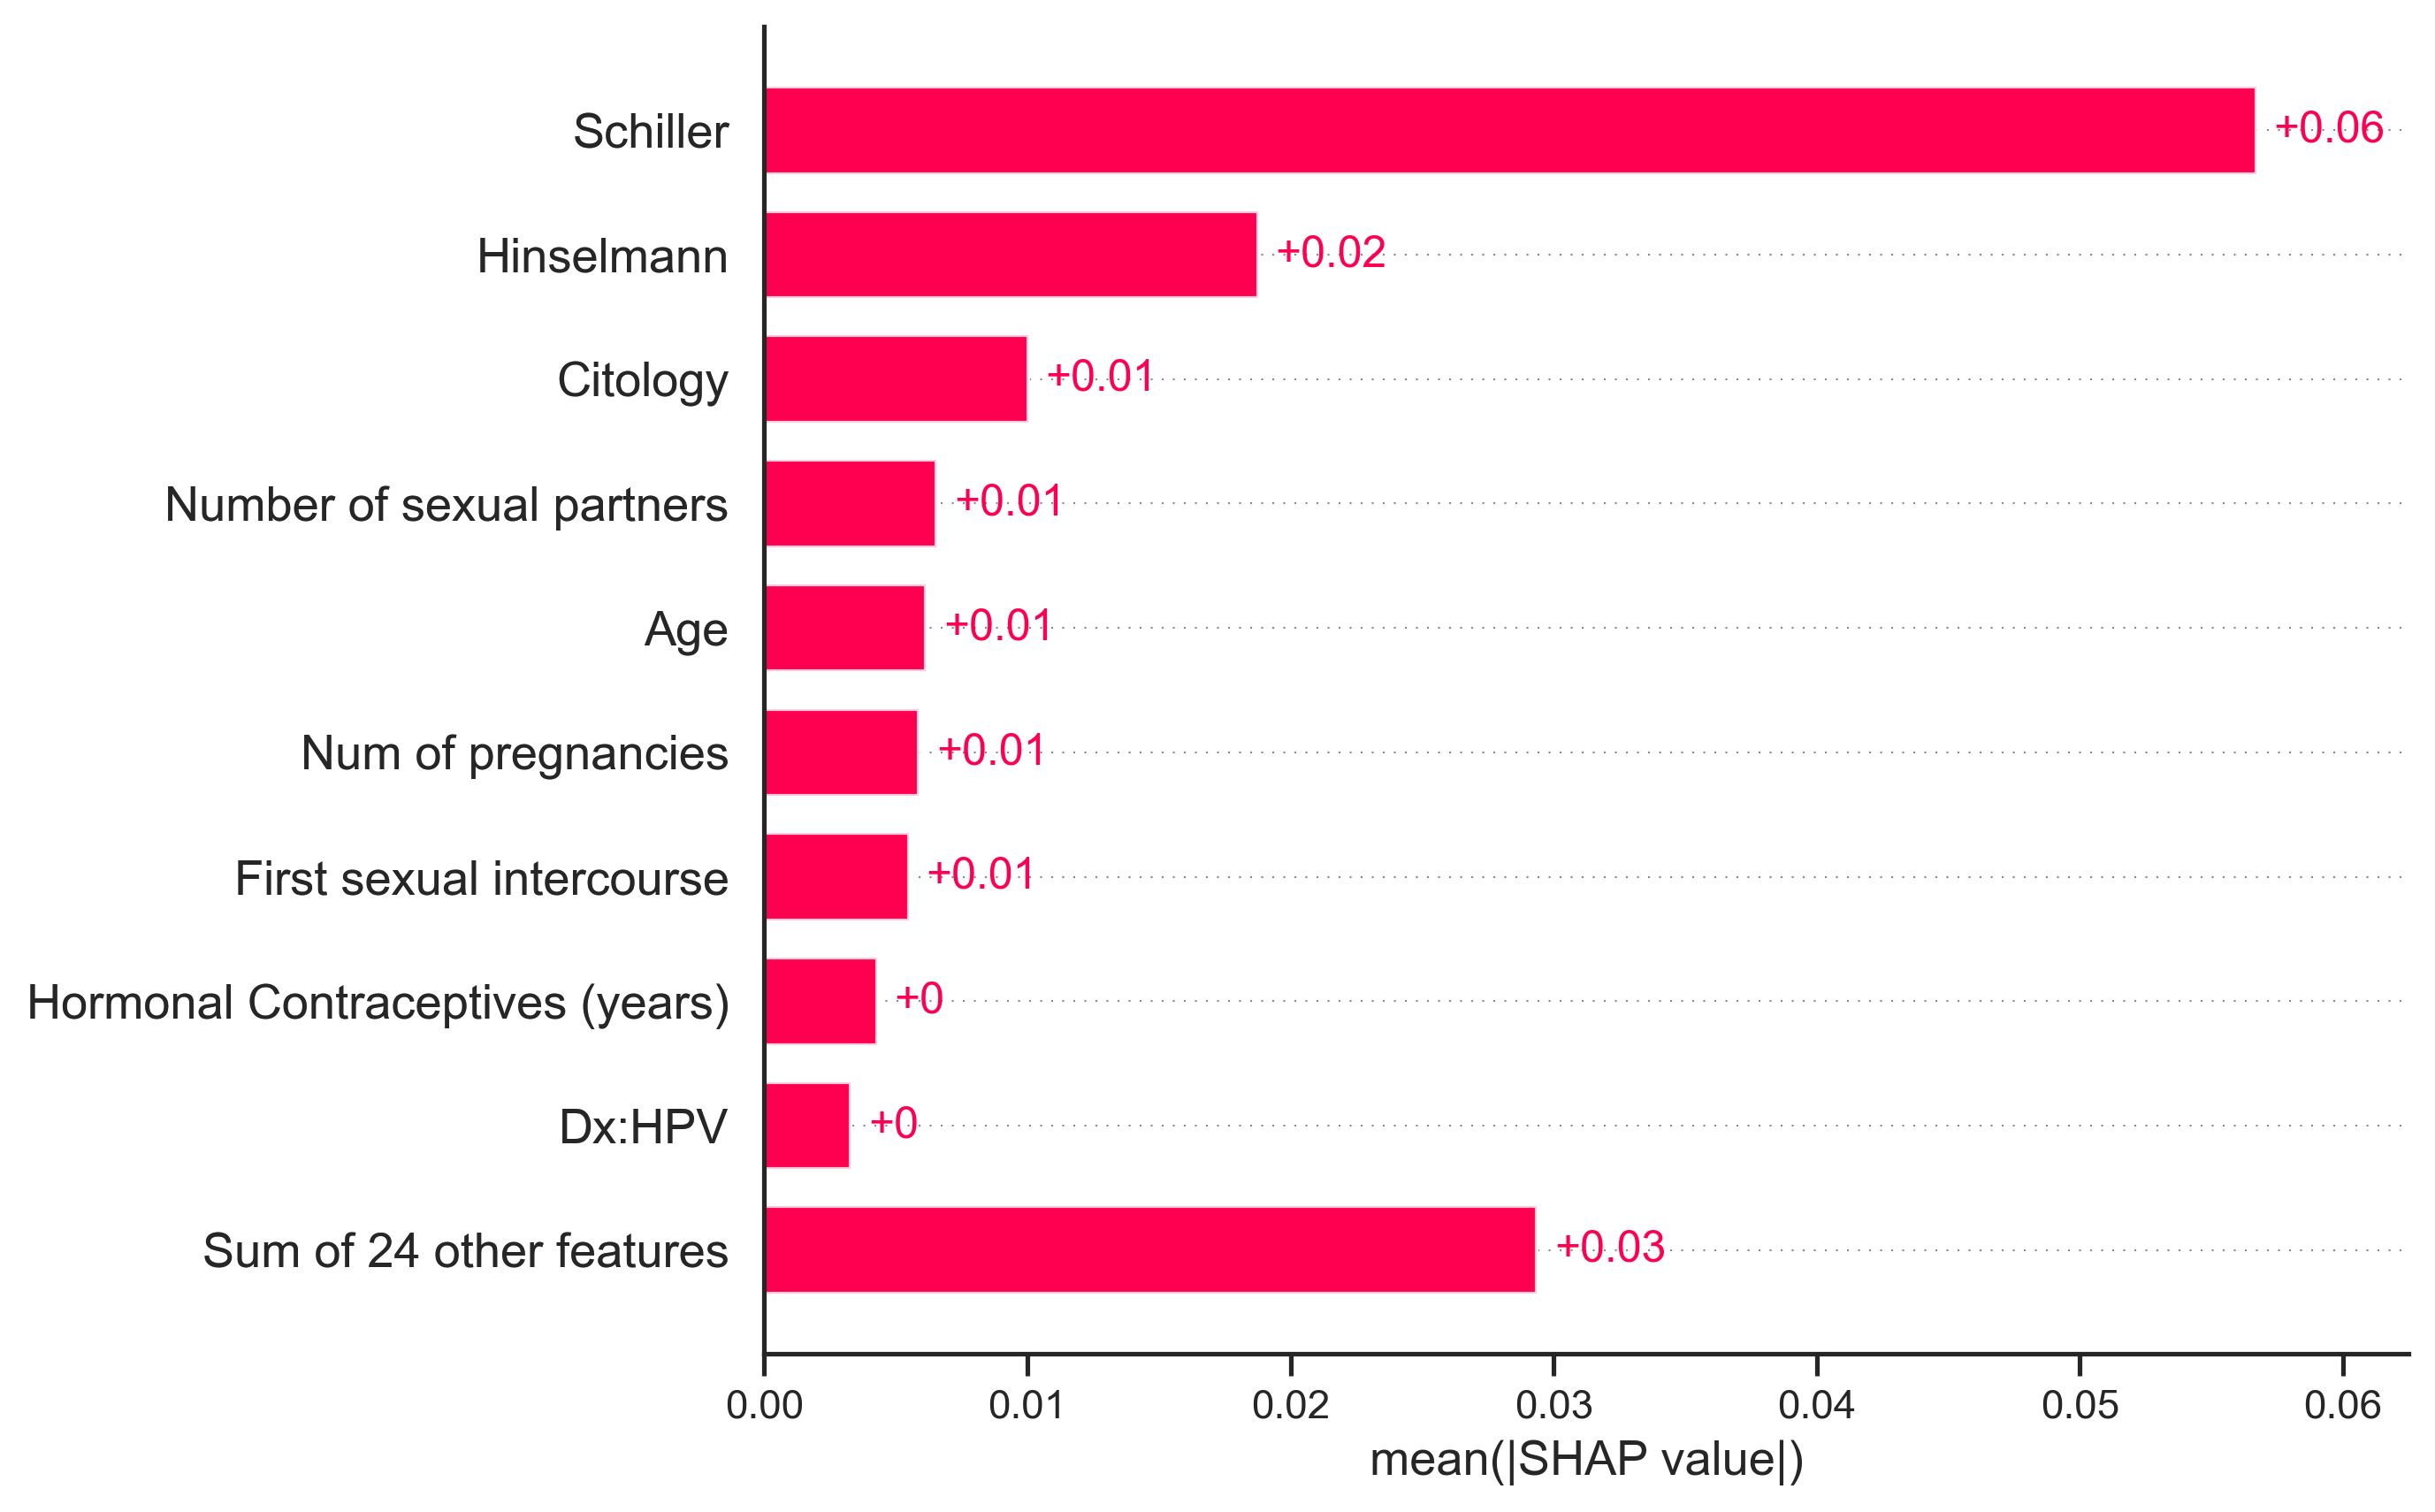

In [145]:
#bar plot shows the importance of the features by calculating the absolute mean of all the shap values.
shap.plots.bar(shap_values)

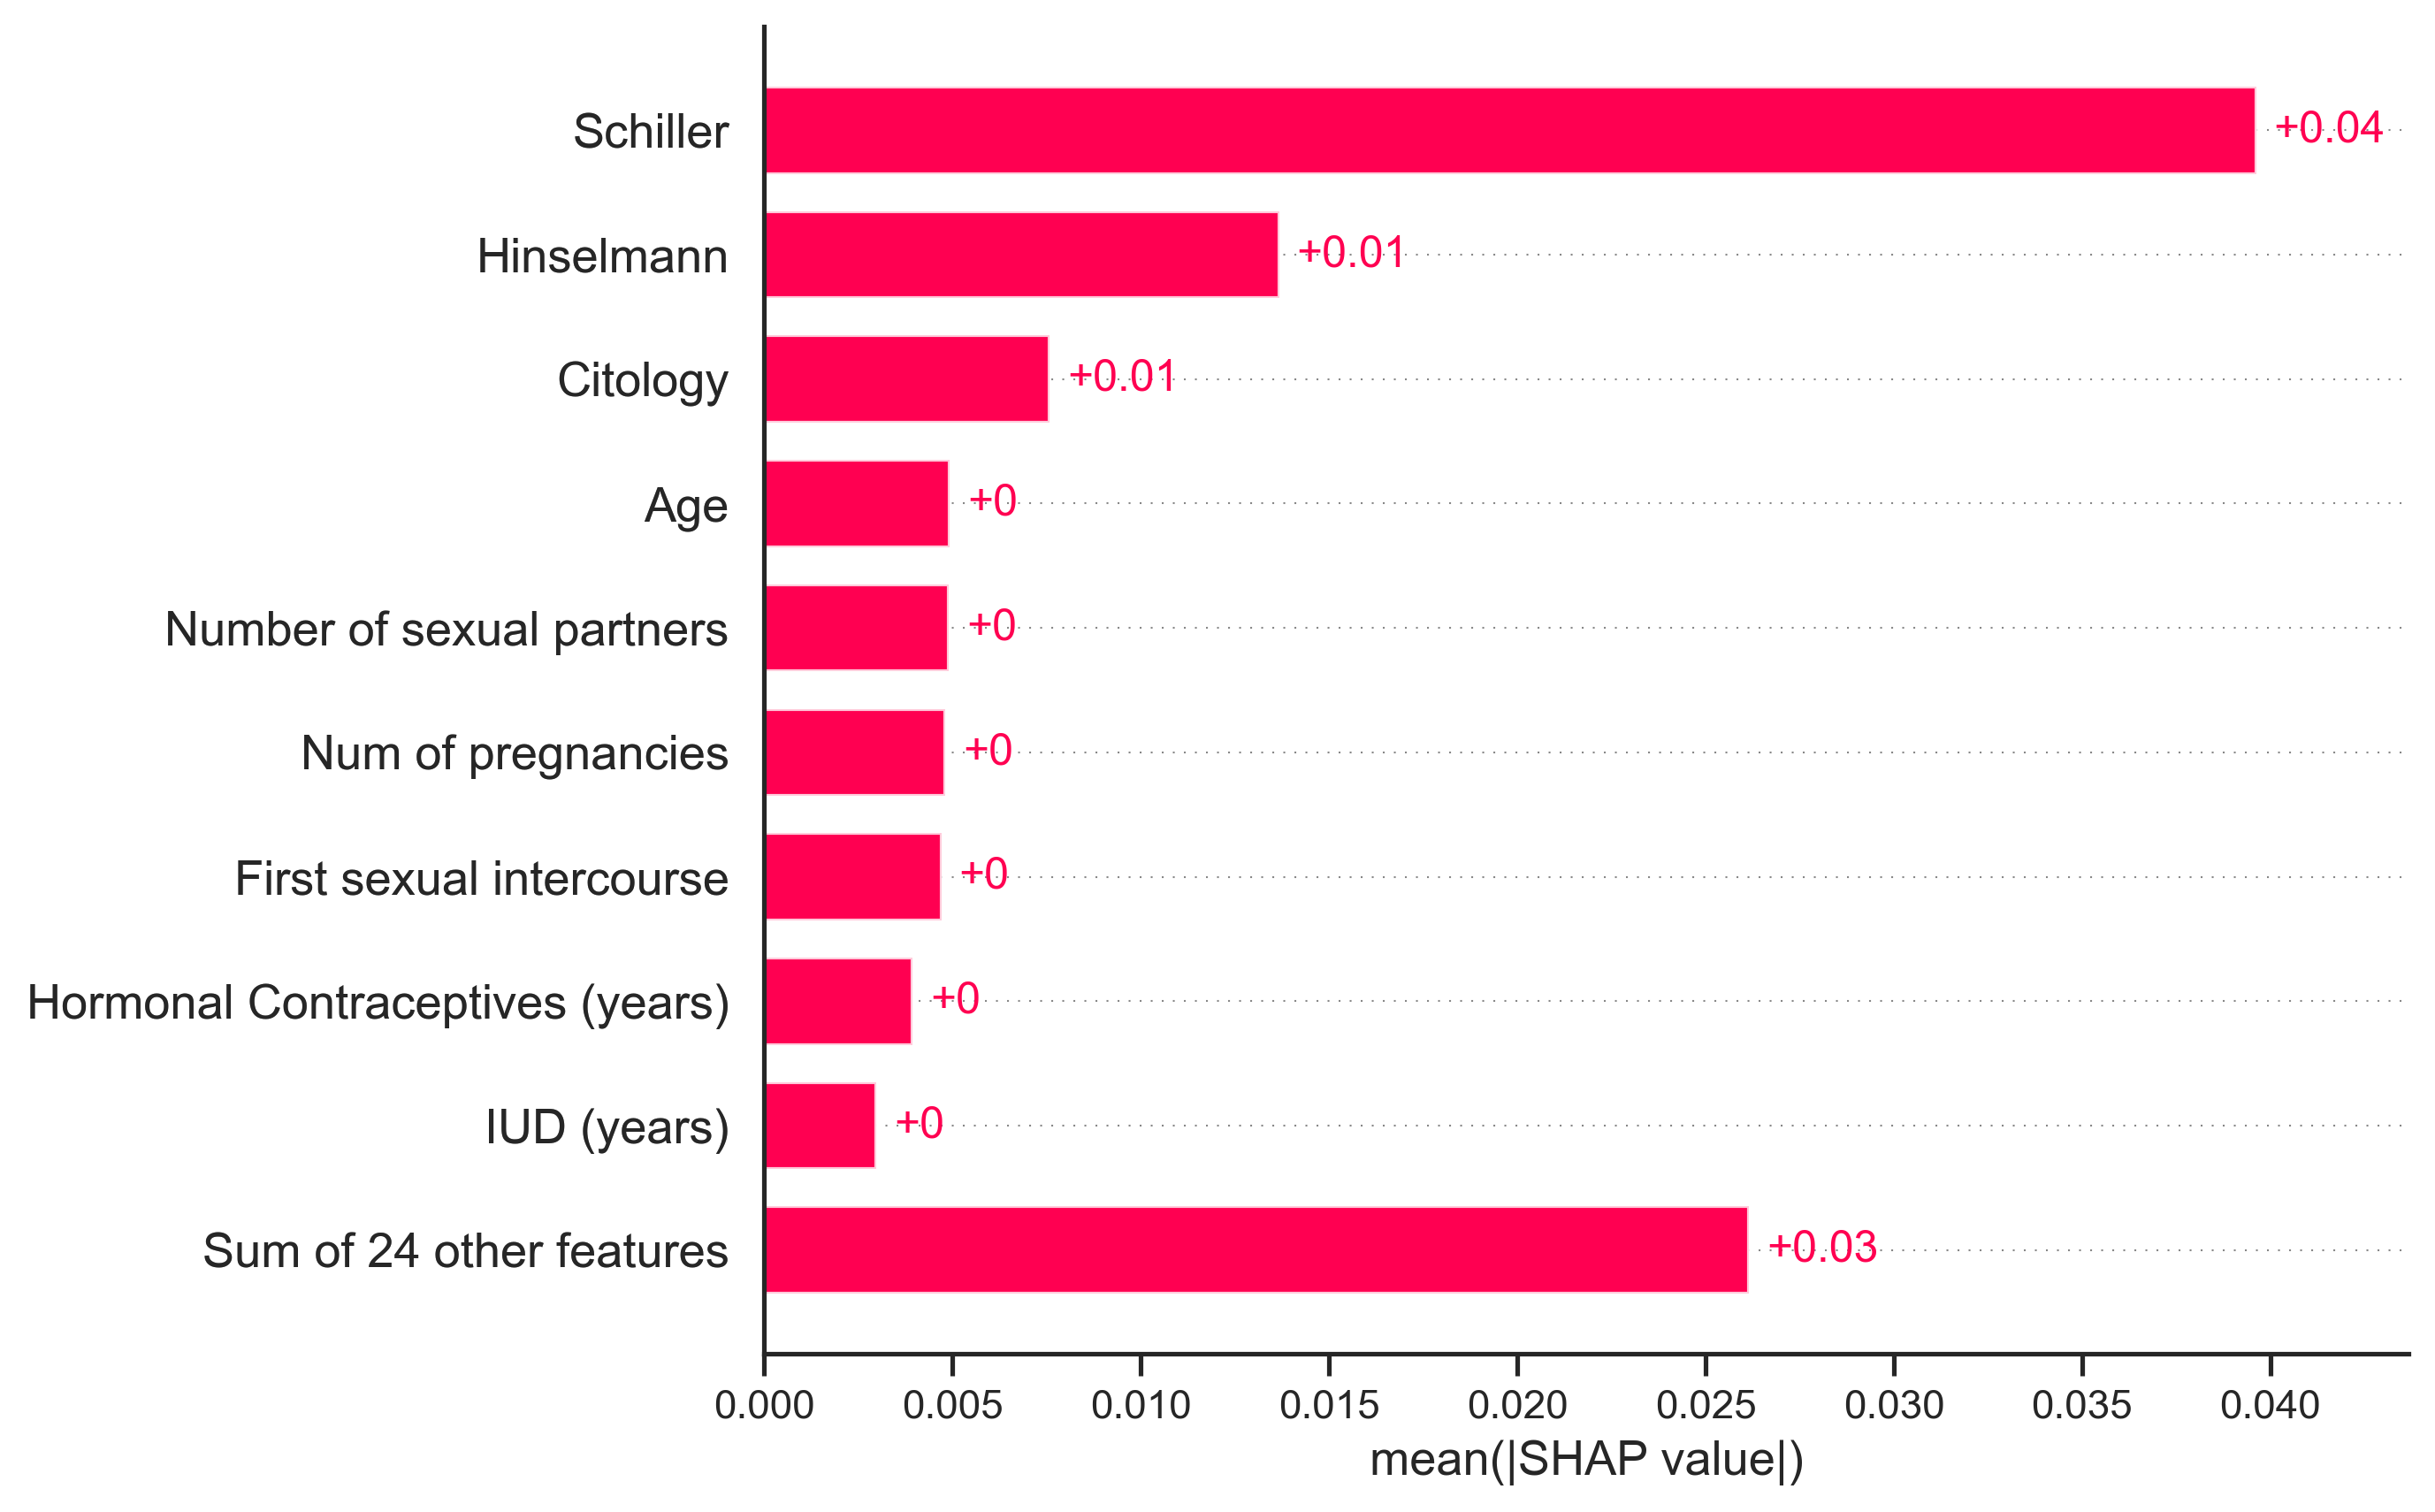

array([ 14,  18,  49,  51,  72,  82, 103, 111, 122, 126, 133, 155, 158,
       180, 193])

In [ ]:
# global importance for benign cases
shap.plots.bar(shap_values[np.where(y_test_lime == 0)[0]])

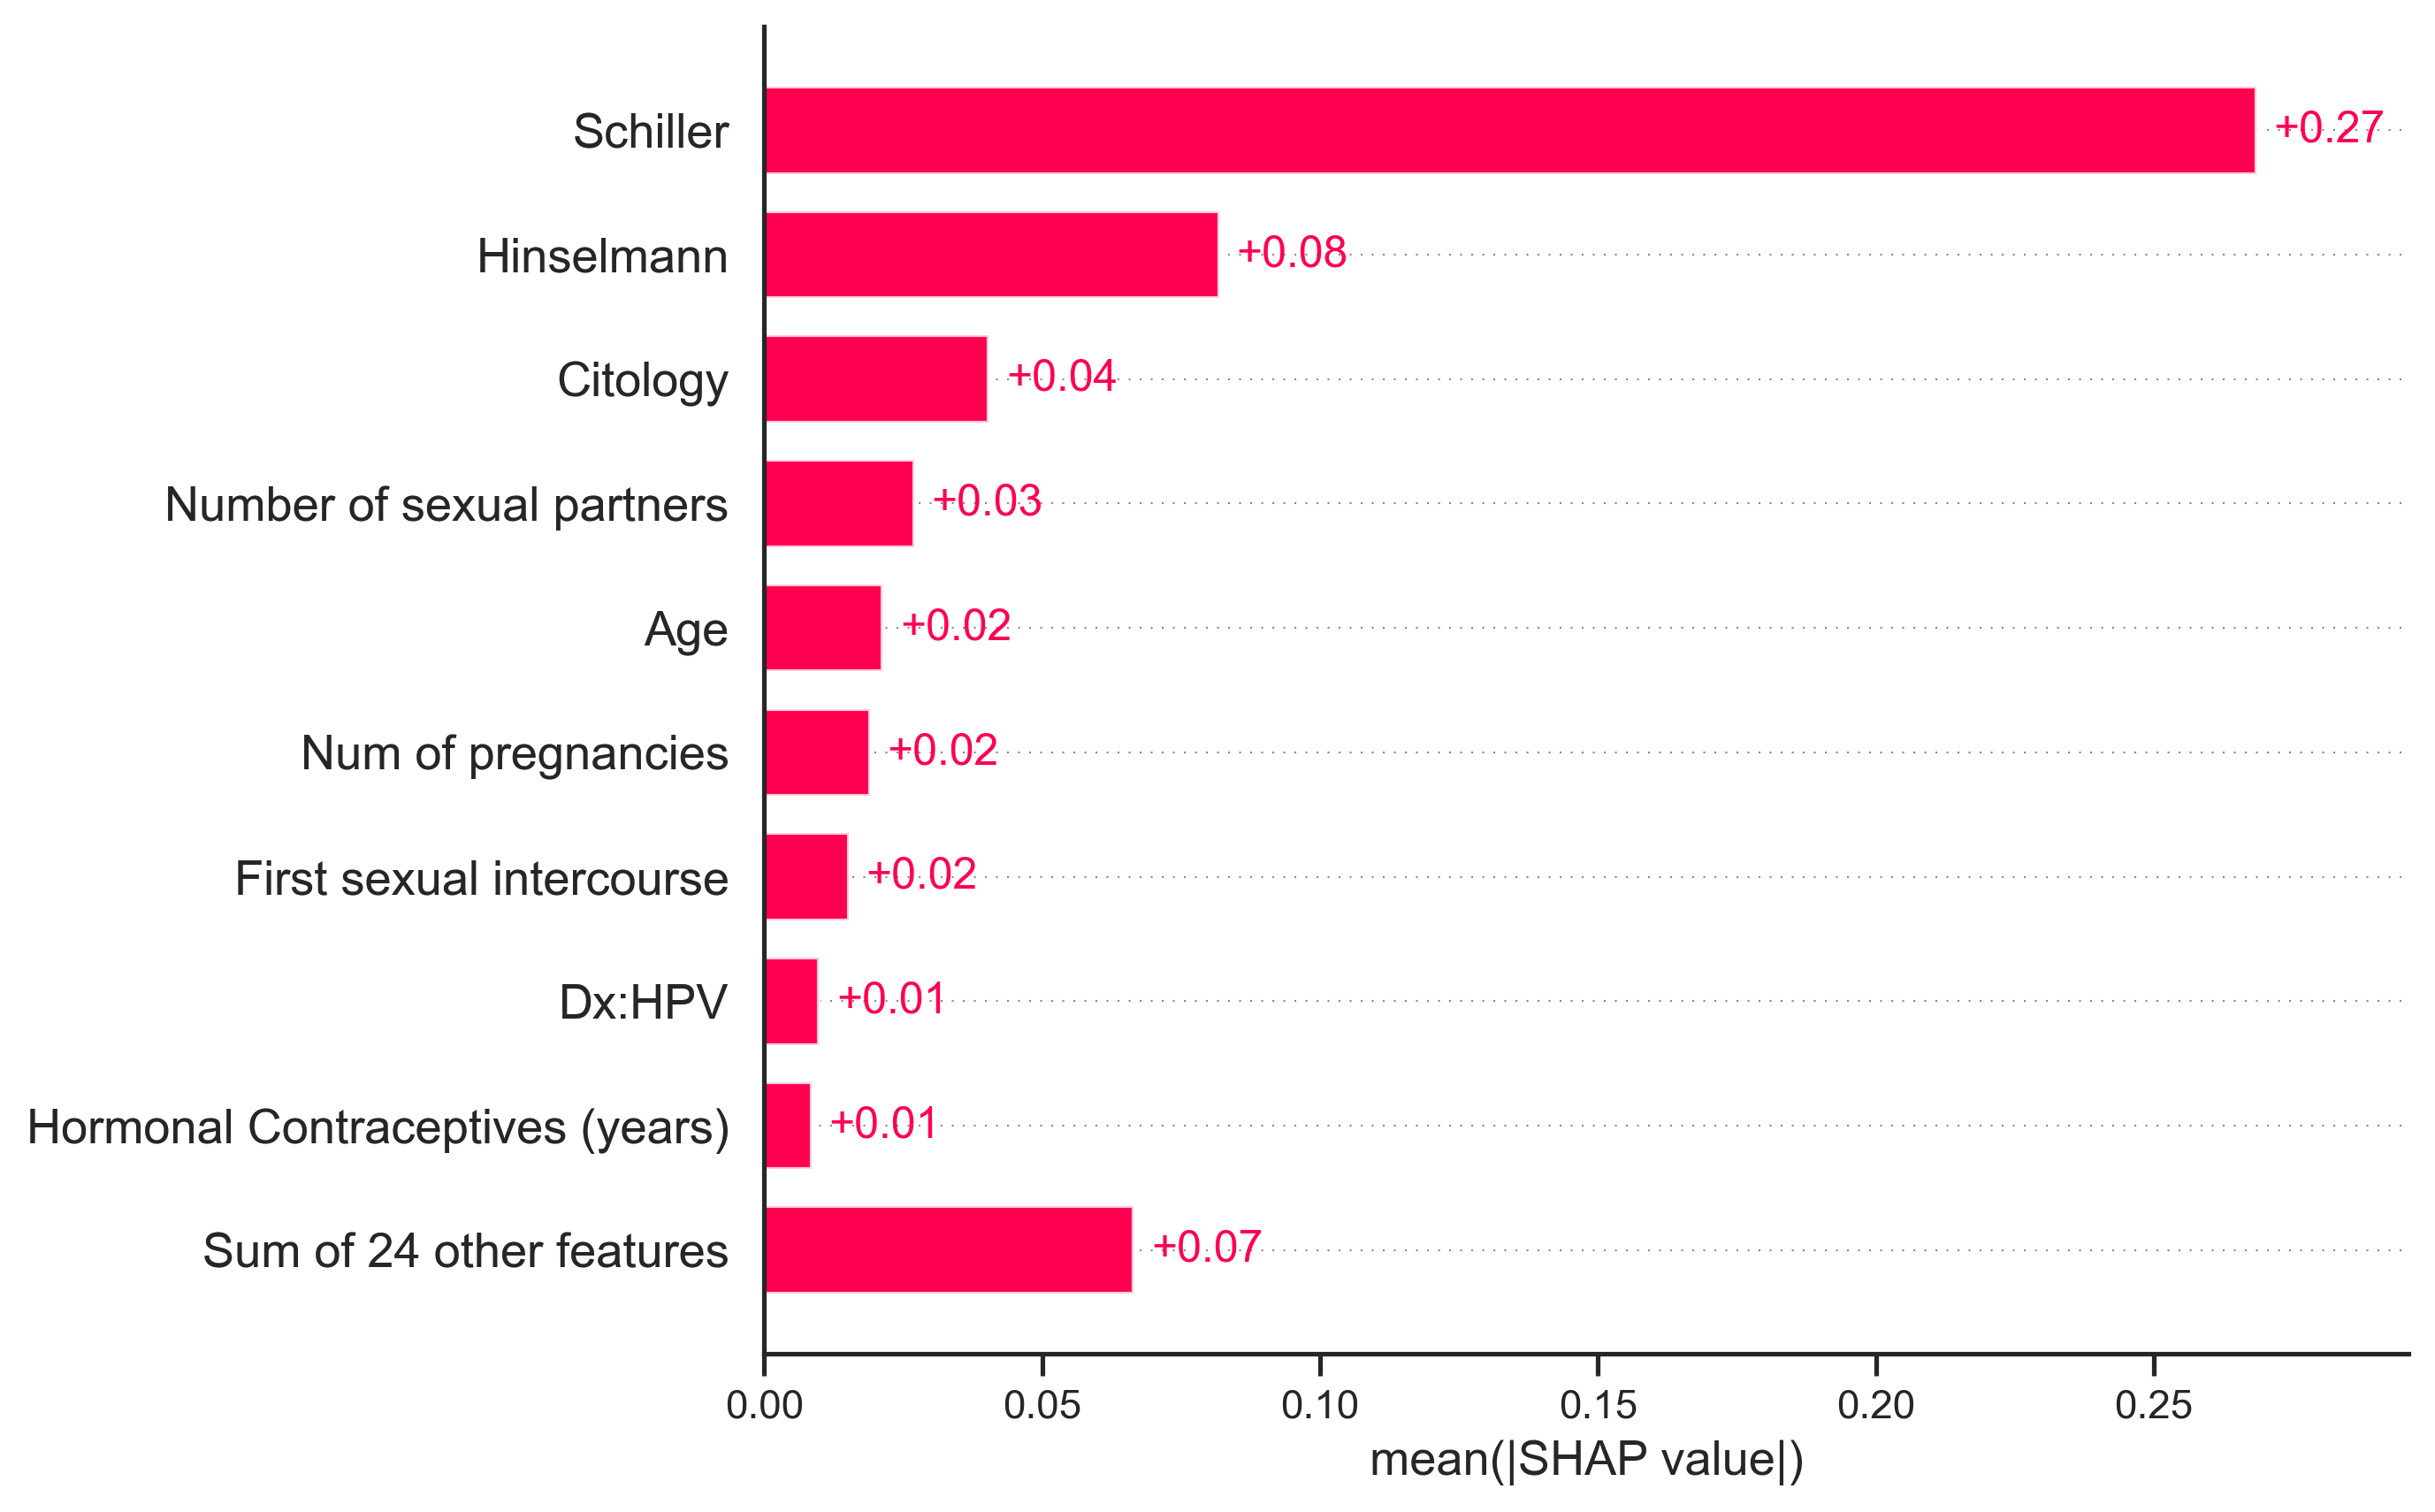

In [ ]:
#global importance malignant cases
shap.plots.bar(shap_values[np.where(y_test_lime == 1)[0]])

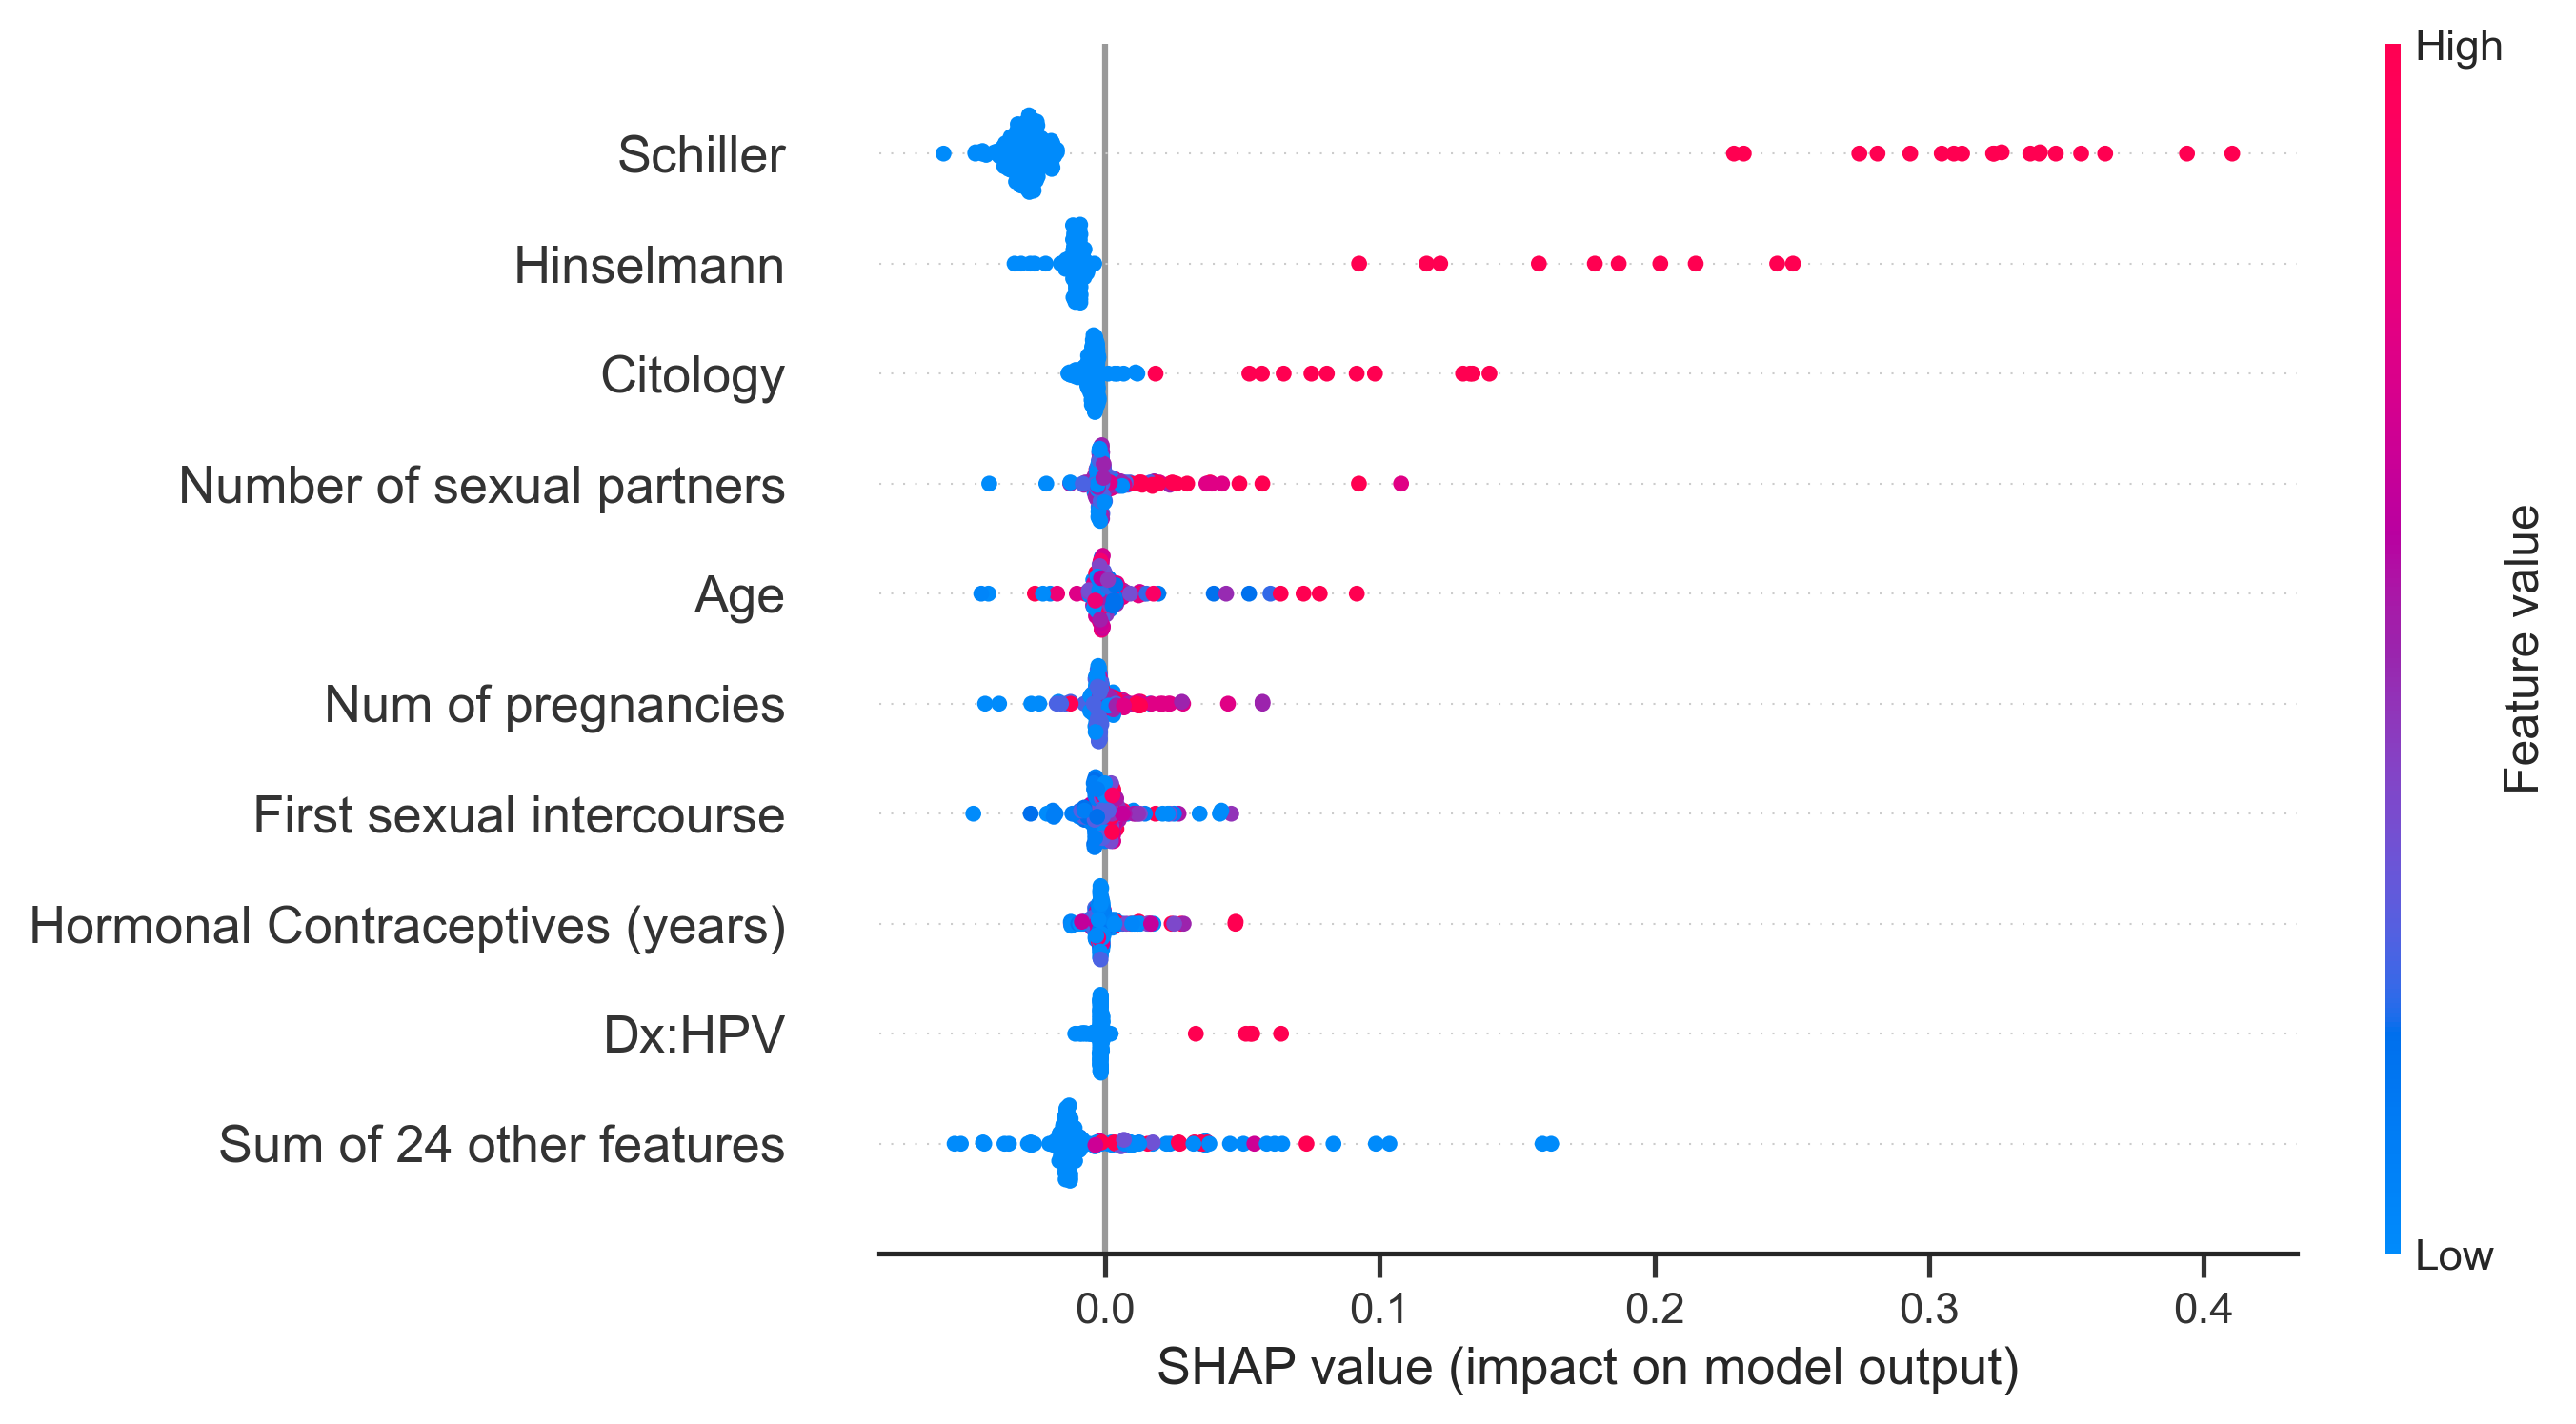

In [146]:
#beeswarm plot shows all the shap values and their feature values.
shap.plots.beeswarm(shap_values)

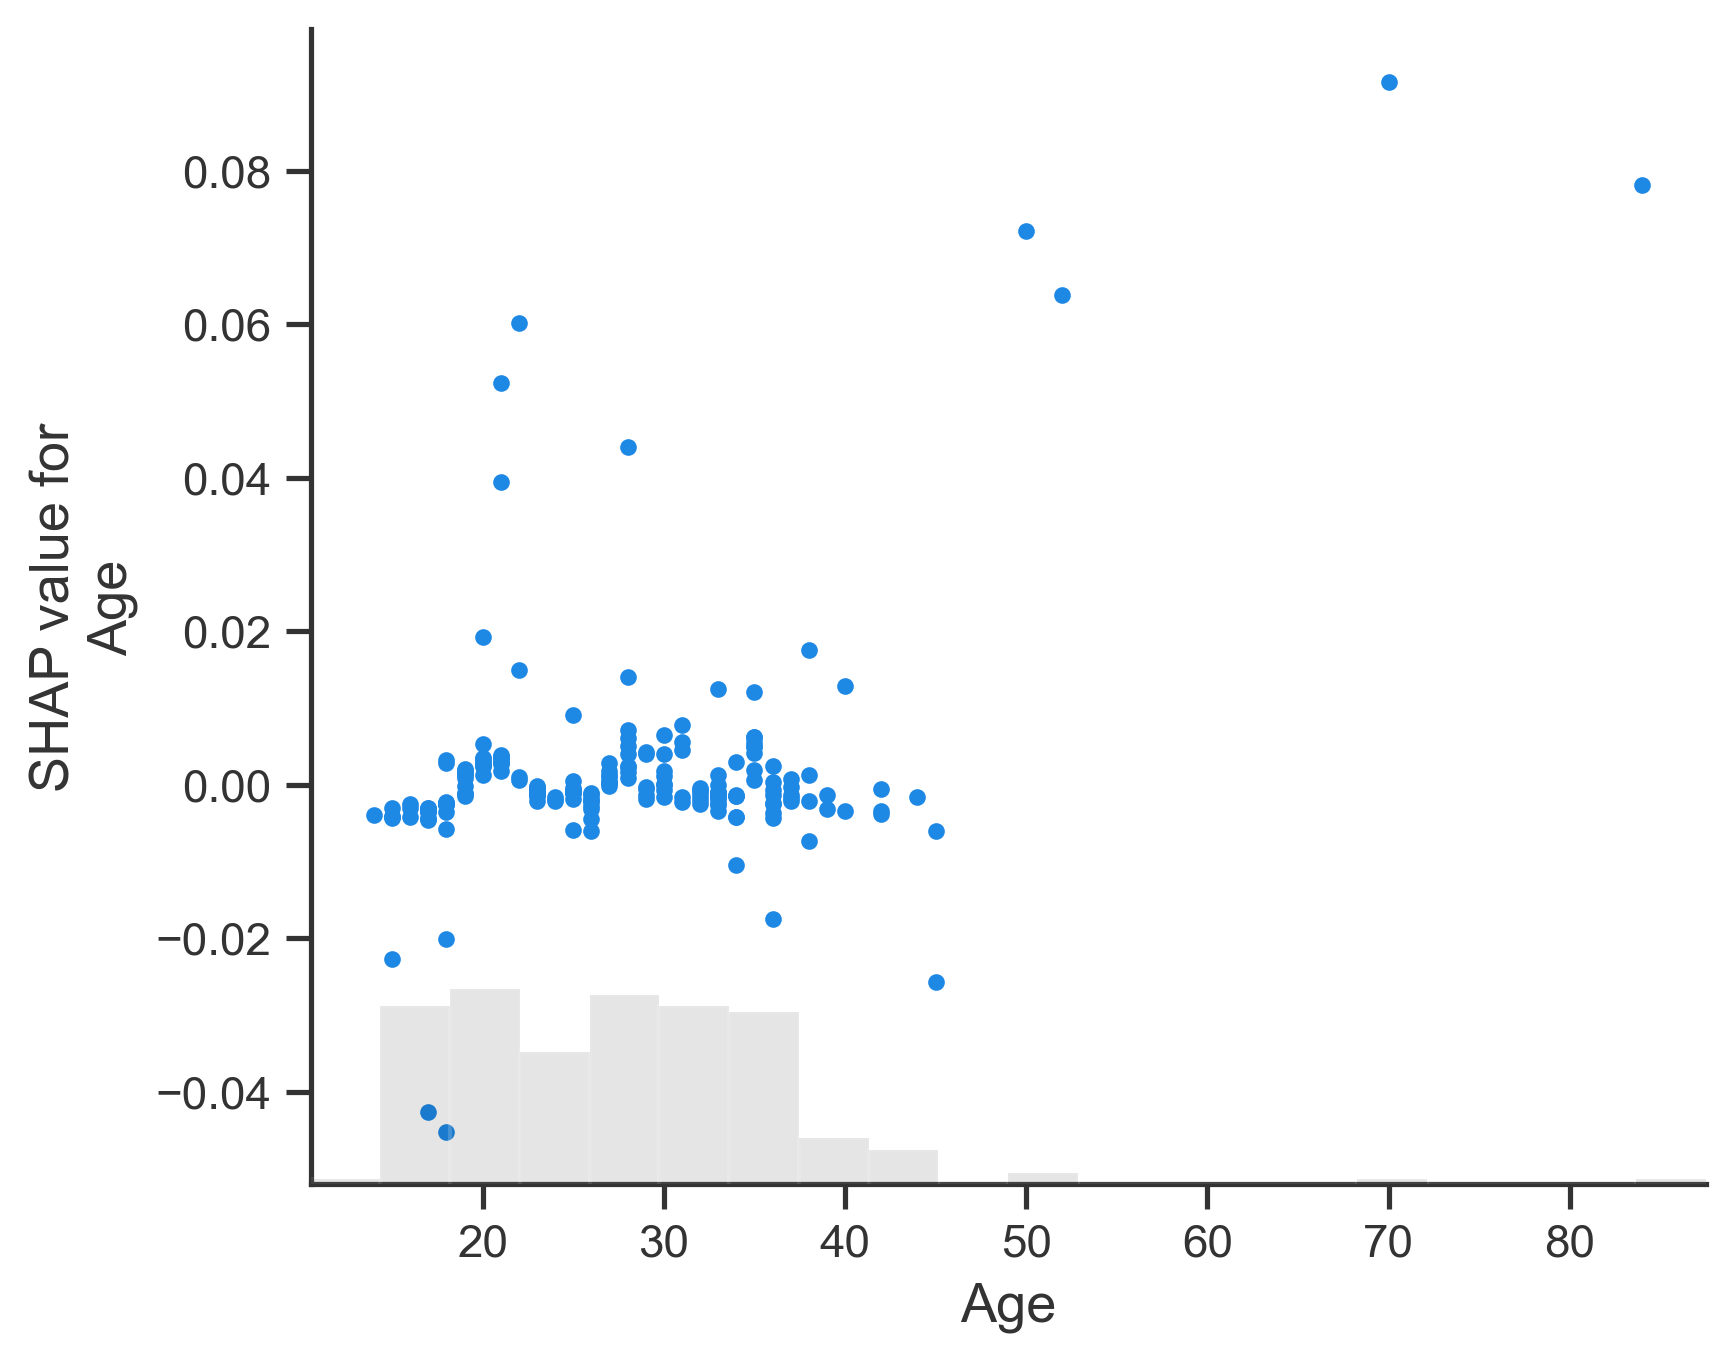

In [147]:
# Dependence plot of shap values for a single feature
shap.plots.scatter(shap_values[:,"Age"])

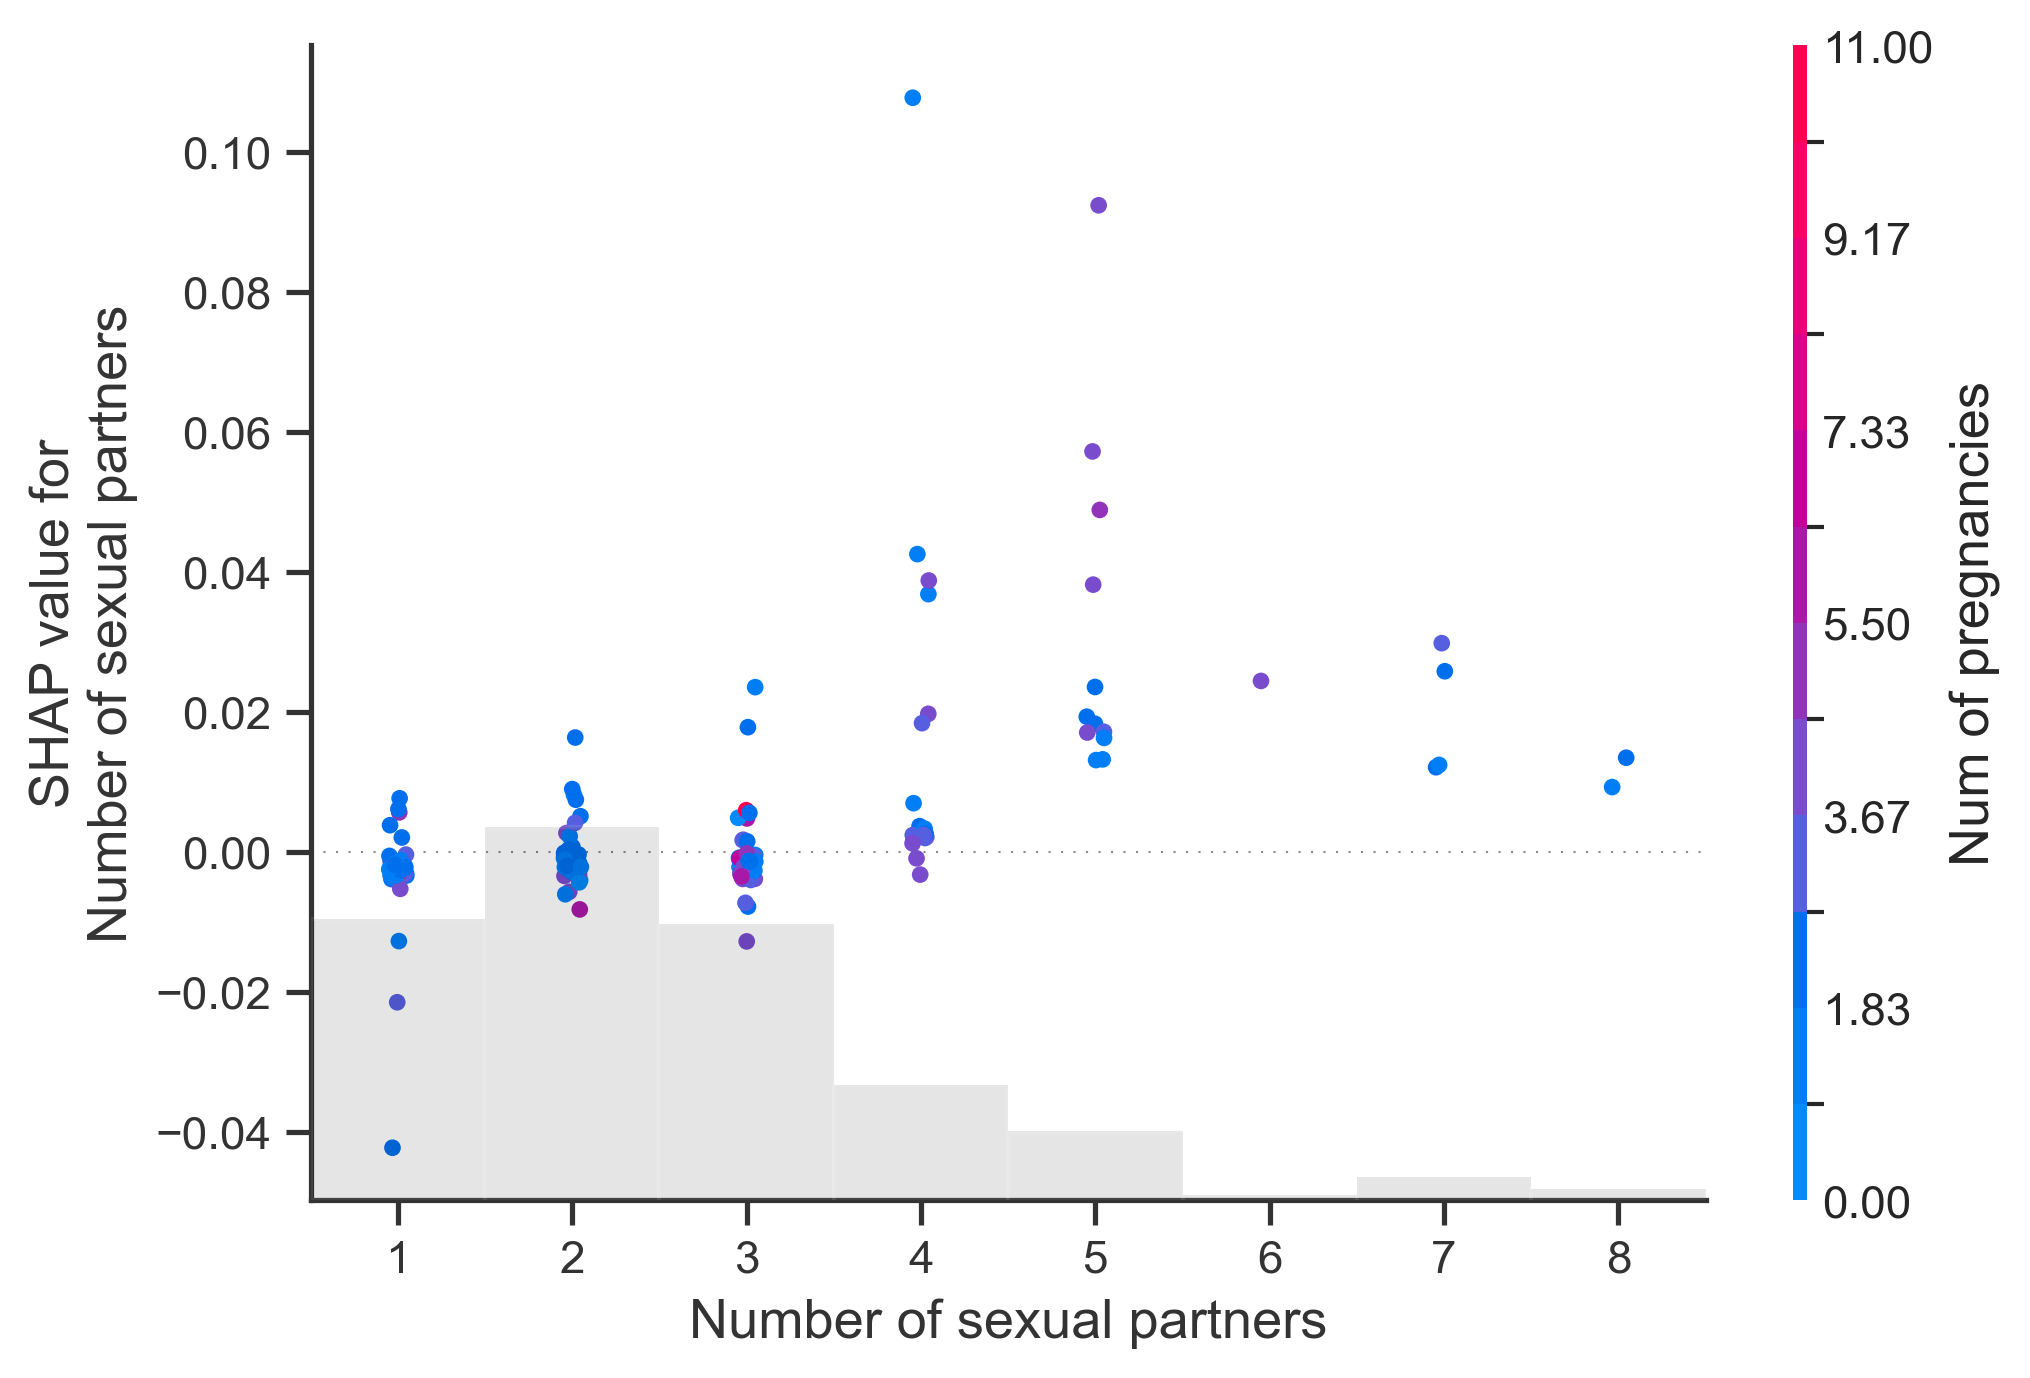

In [148]:
# Dependence plot of shap values for a two features (one on the y-axis and the other as a color code)
shap.plots.scatter(shap_values[:,"Number of sexual partners"],
                   color=shap_values[:,"Num of pregnancies"])